In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn import metrics
import datetime as dt
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

import seaborn as sns

In [2]:
secs_day_limit=86400

# Member data

Gender column in membership data has a couple of NA's, in fact 65%, so not so much to use for this particular column. The data is distributed over 21 cities.

Total count: 6.8 M members (6769473, and all indeed unique, no duplicate msno's)
- Age [bd]: wildely distributed including negative values (plenty of them), thus have to find out later how useful it would be.
- Gender: as already listed before 65 % unkown, most probably not useful.
- City: distributed among 21 cities, most of the users live in city "1", over 5 M (most probably Taipeh)
- 18 different methods to register, out of those 4 are more wildly used (methods 3,4,7,9), the others are rather negligible.
- users registered starting from March 26, 2004 to April 29, 2017.

In [3]:
df_mem=pd.read_csv("data/members_v3.csv")
df_mem

,msno,city,bd,gender,registered_via,registration_init_time
0,Rb9UwLQTrxzBVwCB6+bCcSQWZ9JiNLC9dXtM1oEsZA8=,1,0,NaN,11,20110911
1,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,1,0,NaN,7,20110914
2,cV358ssn7a0f7jZOwGNWS07wCKVqxyiImJUX6xcIwKw=,1,0,NaN,11,20110915
3,9bzDeJP6sQodK73K5CBlJ6fgIQzPeLnRl0p5B77XP+g=,1,0,NaN,11,20110915
4,WFLY3s7z4EZsieHCt63XrsdtfTEmJ+2PnnKLH5GY4Tk=,6,32,female,9,20110915
...,...,...,...,...,...,...
6769468,VSGkb3hyBRUtb/b1MQUZbvOkktS3vKLnhMHW0CF8eyU=,1,0,NaN,7,20151020
6769469,nWjH7glPkZ7jOVaCRwwjlpmp0T1hSWdv8hMJxiWCwKc=,1,0,NaN,7,20151020
6769470,GH+b5+1tlv7ZZXsA8upBzVXMTLyffKcsF7WoU8b5rOI=,15,26,female,4,20151020
6769471,XVlwT3fdCFGKqerEKBzUIjK+jzI6jzSke4cDMVhYyjE=,1,0,NaN,4,20151020


In [3]:
df_mem["registration_init_time_as_dt"]=pd.to_datetime(df_mem["registration_init_time"], format='%Y%m%d', errors='ignore')

Monthly registration numbers show in general an increase up to begin of 2016, then we do observe quite a drop in registration numbers in the dat file but still higher numbers than in 2015

<AxesSubplot:xlabel='registration_init_time_as_dt'>

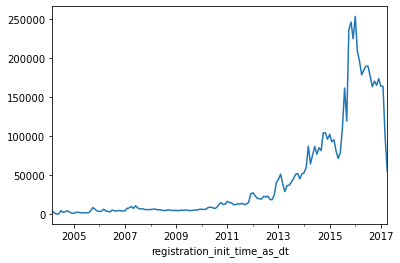

In [4]:
df_mem.groupby(pd.Grouper(key="registration_init_time_as_dt", freq="m")).count()["registration_init_time"].plot()

In [5]:
df_mem

,msno,city,bd,gender,registered_via,registration_init_time,registration_init_time_as_dt
0,Rb9UwLQTrxzBVwCB6+bCcSQWZ9JiNLC9dXtM1oEsZA8=,1,0,NaN,11,20110911,2011-09-11
1,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,1,0,NaN,7,20110914,2011-09-14
2,cV358ssn7a0f7jZOwGNWS07wCKVqxyiImJUX6xcIwKw=,1,0,NaN,11,20110915,2011-09-15
3,9bzDeJP6sQodK73K5CBlJ6fgIQzPeLnRl0p5B77XP+g=,1,0,NaN,11,20110915,2011-09-15
4,WFLY3s7z4EZsieHCt63XrsdtfTEmJ+2PnnKLH5GY4Tk=,6,32,female,9,20110915,2011-09-15
...,...,...,...,...,...,...,...
6769468,VSGkb3hyBRUtb/b1MQUZbvOkktS3vKLnhMHW0CF8eyU=,1,0,NaN,7,20151020,2015-10-20
6769469,nWjH7glPkZ7jOVaCRwwjlpmp0T1hSWdv8hMJxiWCwKc=,1,0,NaN,7,20151020,2015-10-20
6769470,GH+b5+1tlv7ZZXsA8upBzVXMTLyffKcsF7WoU8b5rOI=,15,26,female,4,20151020,2015-10-20
6769471,XVlwT3fdCFGKqerEKBzUIjK+jzI6jzSke4cDMVhYyjE=,1,0,NaN,4,20151020,2015-10-20


In [6]:
print(df_mem["registration_init_time"].min(),df_mem["registration_init_time"].max())

20040326 20170429


In [7]:
df_mem.nunique()

msno                            6769473
city                                 21
bd                                  386
gender                                2
registered_via                       18
registration_init_time             4782
registration_init_time_as_dt       4782
dtype: int64

In [8]:
df_mem.isna().sum()/df_mem.isna().count()

msno                            0.000000
city                            0.000000
bd                              0.000000
gender                          0.654335
registered_via                  0.000000
registration_init_time          0.000000
registration_init_time_as_dt    0.000000
dtype: float64

<AxesSubplot:ylabel='Frequency'>

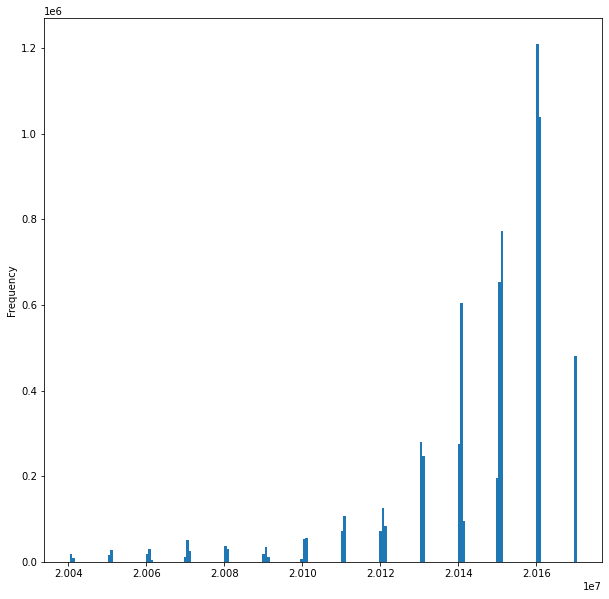

In [9]:
fig, ax = plt.subplots()
df_mem["registration_init_time"].plot(kind="hist",ax=ax,figsize=(10,10),bins=200)

<AxesSubplot:>

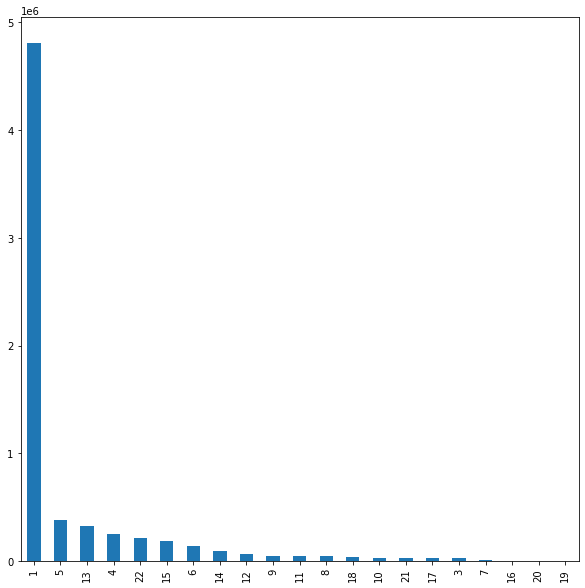

In [10]:
fig, ax = plt.subplots()
df_mem["city"].value_counts().plot(kind="bar",ax=ax,figsize=(10,10))

<AxesSubplot:>

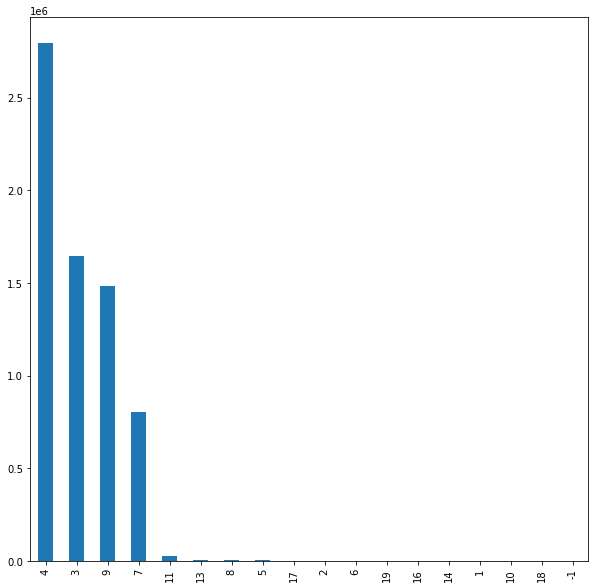

In [11]:
fig, ax = plt.subplots()
df_mem["registered_via"].value_counts().plot(kind="bar",ax=ax,figsize=(10,10))

In [2]:
import time
import psutil
import multiprocessing as mp

#check the number of cores
num_cores = mp.cpu_count()
print("This kernel has ",num_cores,"cores and you can find the information regarding the memory usage:",psutil.virtual_memory())

This kernel has  8 cores and you can find the information regarding the memory usage: svmem(total=17179869184, available=6862934016, percent=60.1, used=8087064576, free=2075623424, active=4821946368, inactive=4771450880, wired=3265118208)


We do have a major issue dealing with user logs with non sensical total_secs values, clearly surpassing the daily amount of seconds, force this values to be exactly the maximum of daily seconds

In [10]:
df_ul_test=pd.read_csv("data/user_logs.csv",nrows=10000)
#df_ul["date_as_dt"]=pd.to_datetime(df_ul["date"], format='%Y%m%d', errors='ignore')
df_ul_test.loc[(abs(df_ul_test['total_secs']) > secs_day_limit) | (df_ul_test['total_secs']<0)].sort_values(by='total_secs')

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
5730,BtZTCXLQ0MvrlsosU/NsJabEZiz8JJz/rAfqjoGgxs8=,20150808,65,0,1,1,17,79,-9.223372e+15
4497,8x6zMayYaSYhXQkZhD+YeBI0oNphdou+ODBpbtJpvBQ=,20150909,4,3,1,1,154,141,-9.223372e+15
5617,ICPC+OqAZLLOCwBYFRg/FdowyUz5Vp7QN7NFRJ4QxXI=,20150501,22,4,2,3,341,146,8.950457e+04
6153,oYrxFRzbSjMD44TPWOtr+jXJkHmRXB5fXjA1W8gMquQ=,20170118,16,3,2,2,389,305,1.007321e+05
6948,ll6VuOeZ15hmzuZ4vrZx04+PB8f37lTTBY8m+QJL38c=,20160106,3,0,0,1,391,19,1.040383e+05
5998,hHkoB2Vc58VXlh8UfonVl2460qdYA8v+9SUHJGM2CSA=,20150804,0,0,0,0,420,338,1.070057e+05
5995,hHkoB2Vc58VXlh8UfonVl2460qdYA8v+9SUHJGM2CSA=,20150217,0,0,0,0,599,24,1.142021e+05
6944,ll6VuOeZ15hmzuZ4vrZx04+PB8f37lTTBY8m+QJL38c=,20150316,1,2,0,0,965,150,1.981146e+05


In [51]:
df_ul_test['total_secs'].loc[abs(df_ul_test['total_secs']) > secs_day_limit] = secs_day_limit


df_ul_test_agg=df_ul_test.groupby("msno").agg(
                                             total_sec_min=('total_secs',lambda x:x[x < secs_day_limit].min()),
                                             total_sec_max=('total_secs',lambda x:x[x < secs_day_limit].max()),
                                             total_sec_mean=('total_secs',lambda x:x[x < secs_day_limit].mean()),
                                             total_sec_median=('total_secs',lambda x:x[x < secs_day_limit].median()),
                                             total_sec_sum=('total_secs',lambda x:x[x < secs_day_limit].sum()),
                                             num_valid_tot_secs_last=('total_secs',lambda x:len(x[x < secs_day_limit])),
                                             total_sec_std=('total_secs',lambda x:x[x < secs_day_limit].std()),
                                             q25_tot_secs=('total_secs',lambda x: x[x < secs_day_limit].quantile(0.25)),
                                             q75_tot_secs=('total_secs',lambda x: x[x < secs_day_limit].quantile(0.75)),
                                        ).reset_index()

df_ul_test_agg_orig=df_ul_test.groupby("msno").agg(
                                             total_sec_min=('total_secs','min'),
                                             total_sec_max=('total_secs','max'),
                                             total_sec_mean=('total_secs','mean'),
                                             total_sec_sum=('total_secs','sum')
                                        ).reset_index()

print(df_ul_test['total_secs'].min(),df_ul_test['total_secs'].max(),df_ul_test['total_secs'].mean(),df_ul_test['total_secs'].sum())
df_ul_test_agg

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


0.007 86400.0 8117.736837716063 2029434209.429


,msno,total_sec_min,total_sec_max,total_sec_mean,total_sec_median,total_sec_sum,num_valid_tot_secs_last,total_sec_std,q25_tot_secs,q75_tot_secs
0,+++dz9ZCWE2HB/47pJU82NJXQzQuZDx1Wm50YSk/kKk=,17132.904,17132.904,17132.904000,17132.904,17132.904,1.0,NaN,17132.9040,17132.90400
1,++95tJZADNg8U8HKbYdxbbXIRsO6pw1zBK4tHI7BtZo=,792.912,43668.864,6674.200167,2779.870,80090.402,12.0,11917.441691,1132.4215,6605.61475
2,++CITmZPtQDWOi01uceGb75QJblInDRhjjGM1MmsiSY=,908.846,1222.820,1065.833000,1065.833,2131.666,2.0,222.013145,987.3395,1144.32650
3,++IfZCXYRIiNalGnmbcGW96v6kAwqQO51Sr7dlhIV34=,662.638,3111.733,1561.170000,909.139,4683.510,3.0,1348.471319,785.8885,2010.43600
4,++NvYbtVD+fgVuflK0hgYV/Y1WA2aYbmmRbCGAQkdPU=,2628.060,2628.060,2628.060000,2628.060,2628.060,1.0,NaN,2628.0600,2628.06000
...,...,...,...,...,...,...,...,...,...,...
49806,zzBpOvDexlle/0PAswlp4AqTBZYw6OtAcBrO9YUzjAs=,2025.761,9188.157,5685.960333,4575.342,51173.643,9.0,2973.009335,3058.0870,8582.41900
49807,zzVLNBeDA/LeQX9kVCwgd/mr0YAbrdUY/jkoJvNoW/c=,2587.009,11010.019,6021.564000,4715.858,30107.820,5.0,3506.671209,3576.8580,8218.07600
49808,zzhOyfpn2MeT6z9IFYgV3ZtMdz+UnWRwMB+9REj0E5M=,877.296,7470.872,4219.653000,4310.791,12658.959,3.0,3297.732663,2594.0435,5890.83150
49809,zzoaEw67A/0C1+4/RgRCBOVK+zsL1xJTMJMTdF42FxM=,37.656,44354.297,6167.610750,1034.040,74011.329,12.0,12668.961485,213.2005,5784.31575


In [38]:
df_ul_test.loc[abs(df_ul_test['total_secs']) == secs_day_limit]

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
4497,8x6zMayYaSYhXQkZhD+YeBI0oNphdou+ODBpbtJpvBQ=,20150909,4,3,1,1,154,141,86400.0
5617,ICPC+OqAZLLOCwBYFRg/FdowyUz5Vp7QN7NFRJ4QxXI=,20150501,22,4,2,3,341,146,86400.0
5730,BtZTCXLQ0MvrlsosU/NsJabEZiz8JJz/rAfqjoGgxs8=,20150808,65,0,1,1,17,79,86400.0
5995,hHkoB2Vc58VXlh8UfonVl2460qdYA8v+9SUHJGM2CSA=,20150217,0,0,0,0,599,24,86400.0
5998,hHkoB2Vc58VXlh8UfonVl2460qdYA8v+9SUHJGM2CSA=,20150804,0,0,0,0,420,338,86400.0
...,...,...,...,...,...,...,...,...,...
992299,AgrSCEd70raiT+kNh2EFjYZcX92ZyhI4C4gkYpauSrY=,20150918,42,3,2,2,49,91,86400.0
994904,bXhMivIiidM2JrdetYoO3pTbNHSl3ln9nVV1QAf7qLw=,20150919,18,4,2,3,86,83,86400.0
995753,sxXMoc2WDZemy2wKhhSEhYL45NANj7t159JMxBK4wTo=,20160108,101,35,24,18,278,267,86400.0
995755,sxXMoc2WDZemy2wKhhSEhYL45NANj7t159JMxBK4wTo=,20160422,49,17,17,17,577,177,86400.0


In [39]:
print(df_ul_test_agg['total_sec_min'].min(),df_ul_test_agg['total_sec_max'].max(),
      df_ul_test_agg['total_sec_mean'].max(),df_ul_test_agg['total_sec_sum'].max(),
      df_ul_test_agg['total_sec_mean'].mean(),df_ul_test_agg['total_sec_sum'].mean())

0.002 86397.347 86368.167 1203353.3879999998 6631.4873273815 39835.02924057053


In [40]:
print(df_ul_test_agg_orig['total_sec_min'].min(),df_ul_test_agg_orig['total_sec_max'].max(),
      df_ul_test_agg_orig['total_sec_mean'].max(),df_ul_test_agg_orig['total_sec_sum'].max(),
      df_ul_test_agg_orig['total_sec_mean'].mean(),df_ul_test_agg_orig['total_sec_sum'].mean())

0.002 86400.0 86400.0 1203353.388 6658.69756295536 40078.64387688483


In [3]:
df_ul_check=pd.read_csv("data/user_logs.csv",nrows=100)
#df_ul["date_as_dt"]=pd.to_datetime(df_ul["date"], format='%Y%m%d', errors='ignore')
df_ul_check.head()

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,rxIP2f2aN0rYNp+toI0Obt/N/FYQX8hcO1fTmmy2h34=,20150513,0,0,0,0,1,1,280.335
1,rxIP2f2aN0rYNp+toI0Obt/N/FYQX8hcO1fTmmy2h34=,20150709,9,1,0,0,7,11,1658.948
2,yxiEWwE9VR5utpUecLxVdQ5B7NysUPfrNtGINaM2zA8=,20150105,3,3,0,0,68,36,17364.956
3,yxiEWwE9VR5utpUecLxVdQ5B7NysUPfrNtGINaM2zA8=,20150306,1,0,1,1,97,27,24667.317
4,yxiEWwE9VR5utpUecLxVdQ5B7NysUPfrNtGINaM2zA8=,20150501,3,0,0,0,38,38,9649.029


In [4]:
df_test=df_ul_check.sort_values(by=['date']).groupby(["msno"])[['date']].diff().rename(columns={"date": "delta_date"})
#df_test=df_test.rename(columns={"date": "delta_date"})
df_test.head()

,delta_date
95,NaN
2,NaN
58,NaN
80,NaN
22,NaN


In [4]:
#no duplicates in v2
df_ul=pd.read_csv("data/user_logs.csv",usecols=['msno'])
#df_ul["date_as_dt"]=pd.to_datetime(df_ul["date"], format='%Y%m%d', errors='ignore')
df_ul.head()

,msno
0,rxIP2f2aN0rYNp+toI0Obt/N/FYQX8hcO1fTmmy2h34=
1,rxIP2f2aN0rYNp+toI0Obt/N/FYQX8hcO1fTmmy2h34=
2,yxiEWwE9VR5utpUecLxVdQ5B7NysUPfrNtGINaM2zA8=
3,yxiEWwE9VR5utpUecLxVdQ5B7NysUPfrNtGINaM2zA8=
4,yxiEWwE9VR5utpUecLxVdQ5B7NysUPfrNtGINaM2zA8=


In [5]:
df_ul_v2=pd.read_csv("data/user_logs_V2.csv",usecols=['msno'])
df_ul_v2

,msno
0,u9E91QDTvHLq6NXjEaWv8u4QIqhrHk72kE+w31Gnhdg=
1,nTeWW/eOZA/UHKdD5L7DEqKKFTjaAj3ALLPoAWsU8n0=
2,2UqkWXwZbIjs03dHLU9KHJNNEvEkZVzm69f3jCS+uLI=
3,ycwLc+m2O0a85jSLALtr941AaZt9ai8Qwlg9n0Nql5U=
4,EGcbTofOSOkMmQyN1NMLxHEXJ1yV3t/JdhGwQ9wXjnI=
...,...
18396357,FGpiy2mB+vXLKziYRcY/xJcJEFJfRDfUqlU+p760f7E=
18396358,iZRjKNMrw5ffEbfXODLhV/0tJLPbOH3am1WYDgqBf8Q=
18396359,yztw4Y0EggG0w2wPkbMZx7ke7saSx7dLSfMheHZG/DQ=
18396360,swCHwkNx30/aENjq30qqaLlm7bUUytbMXdz1bH7g0Jk=


In [6]:
df_ul=df_ul.append(df_ul_v2)
df_ul

,msno
0,rxIP2f2aN0rYNp+toI0Obt/N/FYQX8hcO1fTmmy2h34=
1,rxIP2f2aN0rYNp+toI0Obt/N/FYQX8hcO1fTmmy2h34=
2,yxiEWwE9VR5utpUecLxVdQ5B7NysUPfrNtGINaM2zA8=
3,yxiEWwE9VR5utpUecLxVdQ5B7NysUPfrNtGINaM2zA8=
4,yxiEWwE9VR5utpUecLxVdQ5B7NysUPfrNtGINaM2zA8=
...,...
18396357,FGpiy2mB+vXLKziYRcY/xJcJEFJfRDfUqlU+p760f7E=
18396358,iZRjKNMrw5ffEbfXODLhV/0tJLPbOH3am1WYDgqBf8Q=
18396359,yztw4Y0EggG0w2wPkbMZx7ke7saSx7dLSfMheHZG/DQ=
18396360,swCHwkNx30/aENjq30qqaLlm7bUUytbMXdz1bH7g0Jk=


In [7]:
msno_list=df_ul['msno'].unique().tolist()
len(msno_list)

5339422

In [8]:
chunk_counter=250000
test_msno_lists= [msno_list[x:x+chunk_counter] for x in range(0, len(msno_list), chunk_counter)]



In [11]:
day_period=30

chunk_size = math.ceil(len(df_ul)/50.)
#print(chunksize)

sum_test=0
df_agg_per_user_list=[]
for ind,m_list in enumerate(test_msno_lists):
    sum_test=0
    print(m_list[0:1])
    small_dfs_list=[]
    size_list=[]
    #if(ind>1):
    #    continue
    print(len(m_list),ind)
    for chunk in pd.read_csv("data/user_logs.csv", chunksize=chunk_size):
        small_df=chunk[chunk['msno'].isin(m_list)]
        small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit
        if(small_df.size>0):
            print(small_df.shape,small_df['total_secs'].dtype,small_df['total_secs'].max(),small_df['total_secs'].min(),small_df['total_secs'].sum())
        sum_test=sum_test+len(small_df)
        small_dfs_list.append(small_df)
        size_list.append(len(small_df))
    print("end off first user logs",sum_test)
    for chunk_V2 in pd.read_csv("data/user_logs_V2.csv", chunksize=chunk_size):
        small_df=chunk_V2[chunk_V2['msno'].isin(m_list)]
        small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit
        if(small_df.size>0):
            print("V2",small_df.shape, small_df['total_secs'].max(),small_df['total_secs'].min(),small_df['total_secs'].sum())
            sum_test=sum_test+len(small_df)
            size_list.append(len(small_df))
        #sum_test=sum_test+len(small_df)
        small_dfs_list.append(small_df)
    large_df = pd.concat(small_dfs_list, ignore_index=True)
    print("len before",sum_test,large_df.shape,min(size_list),max(size_list))
    large_df = large_df.drop_duplicates(ignore_index=True)
    #date	num_25	num_50	num_75	num_985	num_100	num_unq	total_secs
    large_df['date']=pd.to_datetime(large_df['date'], format='%Y%m%d', errors='ignore')
    print("len after",sum_test,large_df.shape)
    delta_data_large_df = large_df.sort_values(by=['date']).groupby(["msno"])[['date']].diff().rename(columns={"date": "delta_date"})
    
    #df_delta_tra=df_tra.sort_values(by=["transaction_date_dt"]).groupby(["msno"])[["actual_amount_paid","transaction_date_dt","membership_expire_date_dt"]].shift()

    #df_delta_tra=df_delta_tra.rename(columns={"actual_amount_paid": "actual_amount_paid_prev", "transaction_date_dt": "transaction_date_dt_prev", "membership_expire_date_dt": "membership_expire_date_dt_prev_prel"})

    large_df=pd.concat([large_df, delta_data_large_df], axis=1, sort=False)
    #print(large_df.sort_values(by=["msno","date"]).head(50))
    
    df_agg_first_last_date = large_df.groupby(["msno"]).agg(first_act_date=('date','min'),
                                                    last_act_date=('date','max')).reset_index()
    large_df=large_df.merge(df_agg_first_last_date, on='msno')
    large_df['activity_duration']=large_df['last_act_date']-large_df['first_act_date']
    large_df['activity_duration']=large_df['activity_duration'].dt.days
    large_df['delta_date']=large_df['delta_date'].dt.days-1
    
    
    #print(large_df.sort_values(by=["msno","date"]).head(50))
    """
    df_agg_temp_deltas_first=large_df[(large_df['delta_date'].notna()) & 
                                    (large_df['date']<(large_df['first_act_date']+dt.timedelta(days=day_period)))
                                   ].groupby(["msno"]).agg(
                                                n_max_break_first=('delta_date','max'),
                                                n_min_break_first=('delta_date','min'),
                                                n_mean_break_first=('delta_date','mean'),
                                                n_mode_break_first=('delta_date',lambda x: pd.Series.mode(x)[0]),
                                                n_median_break_first=('delta_date','median')
                                                ).reset_index()
    """
    df_agg_temp_deltas_last=large_df[(large_df['delta_date'].notna()) & 
                                    (large_df['date']>(large_df['last_act_date']-dt.timedelta(days=day_period)))
                                   ].groupby(["msno"]).agg(
                                                n_max_break_last=('delta_date','max'),
                                                n_min_break_last=('delta_date','min'),
                                                n_mean_break_last=('delta_date','mean'),
                                                n_mode_break_last=('delta_date',lambda x: pd.Series.mode(x)[0]),
                                                n_median_break_last=('delta_date','median')
                                                ).reset_index()

    
    df_agg_temp_deltas=large_df[large_df['delta_date'].notna()].groupby(["msno"]).agg(
                                                n_max_break=('delta_date','max'),
                                                n_min_break=('delta_date','min'),
                                                n_mean_break=('delta_date','mean'),
                                                n_mode_break=('delta_date',lambda x: pd.Series.mode(x)[0]),
                                                n_median_break=('delta_date','median')
                                                ).reset_index()
    
    
    df_agg_temp_last=large_df[(large_df['date']>(large_df['last_act_date']-dt.timedelta(days=day_period)))].groupby(
                                       ["msno"]).agg(
                                                n_active_days_last=('date','nunique'),
                                                sum_num_25_last=('num_25','sum'),
                                                sum_num_50_last=('num_50','sum'),
                                                sum_num_75_last=('num_75','sum'),
                                                sum_num_985_last=('num_985','sum'),
                                                sum_num_100_last=('num_100','sum'),
                                                sum_num_unq_last=('num_unq','sum'),
                                                tot_secs_last=('total_secs',lambda x:x[x < secs_day_limit].sum()),
                                                num_valid_tot_secs_last=('total_secs',lambda x:len(x[x < secs_day_limit])),
                                                mean_num_25_last=('num_25','mean'),
                                                #max_num_25_last=('num_25','max'),
                                                median_num_25_last=('num_25','median'),
                                                q25_num_25_last=('num_25',lambda x: x.quantile(0.25)),
                                                q75_num_25_last=('num_25',lambda x: x.quantile(0.75)),
                                                std_num_25_last=('num_25','std'),
                                                #mean_num_50_last=('num_50','mean'),
                                                #max_num_50_last=('num_50','max'),
                                                median_num_50_last=('num_50','median'),
                                                #q25_num_50_last=('num_50',lambda x: x.quantile(0.25)),
                                                #q75_num_50_last=('num_50',lambda x: x.quantile(0.75)),
                                                std_num_50_last=('num_50','std'),
                                                #mean_num_75_last=('num_75','mean'),
                                                #max_num_75_last=('num_75','max'),
                                                median_num_75_last=('num_75','median'),
                                                #q25_num_75_last=('num_75',lambda x: x.quantile(0.25)),
                                                #q75_num_75_last=('num_75',lambda x: x.quantile(0.75)),
                                                std_num_75_last=('num_75','std'),
                                                #mean_num_985_last=('num_985','mean'),
                                                #max_num_985_last=('num_985','max'),
                                                median_num_985_last=('num_985','median'),
                                                #q25_num_985_last=('num_985',lambda x: x.quantile(0.25)),
                                                #q75_num_985_last=('num_985',lambda x: x.quantile(0.75)),
                                                std_num_985_last=('num_985','std'),
                                                mean_num_100_last=('num_100','mean'),
                                                #max_num_100_last=('num_100','max'),
                                                median_num_100_last=('num_100','median'),
                                                q25_num_100_last=('num_100',lambda x: x.quantile(0.25)),
                                                q75_num_100_last=('num_100',lambda x: x.quantile(0.75)),
                                                std_num_100_last=('num_100','std'),
                                                mean_tot_secs_last=('total_secs',lambda x:x[x < secs_day_limit].mean()),
                                                #max_tot_secs_last=('total_secs',,lambda x:x[x < secs_day_limit].max()),
                                                median_tot_secs_last=('total_secs',lambda x:x[x < secs_day_limit].median()),
                                                q25_tot_secs_last=('total_secs',lambda x: x[x < secs_day_limit].quantile(0.25)),
                                                q75_tot_secs_last=('total_secs',lambda x: x[x < secs_day_limit].quantile(0.75)),
                                                std_tot_secs_last=('total_secs',lambda x: x[x < secs_day_limit].std())                                        
                                        
    ).reset_index()
    
    
    
    
    
    df_agg_temp=large_df.groupby(["msno"]).agg(activity_duration=('activity_duration','min'),
                                                last_date_active=('date','max'),
                                                n_active_days=('date','nunique'),
                                                sum_num_25=('num_25','sum'),
                                                sum_num_50=('num_50','sum'),
                                                sum_num_75=('num_75','sum'),
                                                sum_num_985=('num_985','sum'),
                                                sum_num_100=('num_100','sum'),
                                                sum_num_unq=('num_unq','sum'),
                                                tot_secs=('total_secs',lambda x:x[x < secs_day_limit].sum()),
                                                num_valid_tot_secs=('total_secs',lambda x:len(x[x < secs_day_limit])),
                                                mean_num_25=('num_25','mean'),
                                                #max_num_25=('num_25','max'),
                                                median_num_25=('num_25','median'),
                                                q25_num_25=('num_25',lambda x: x.quantile(0.25)),
                                                q75_num_25=('num_25',lambda x: x.quantile(0.75)),
                                                std_num_25=('num_25','std'),
                                                #mean_num_50=('num_50','mean'),
                                                #max_num_50=('num_50','max'),
                                                median_num_50=('num_50','median'),
                                                #q25_num_50=('num_50',lambda x: x.quantile(0.25)),
                                                #q75_num_50=('num_50',lambda x: x.quantile(0.75)),
                                                std_num_50=('num_50','std'),
                                                #mean_num_75=('num_75','mean'),
                                                #max_num_75=('num_75','max'),
                                                median_num_75=('num_75','median'),
                                                #q25_num_75=('num_75',lambda x: x.quantile(0.25)),
                                                #q75_num_75=('num_75',lambda x: x.quantile(0.75)),
                                                std_num_75=('num_75','std'),
                                                #mean_num_985=('num_985','mean'),
                                                #max_num_985=('num_985','max'),
                                                median_num_985=('num_985','median'),
                                                #q25_num_985=('num_985',lambda x: x.quantile(0.25)),
                                                #q75_num_985=('num_985',lambda x: x.quantile(0.75)),
                                                std_num_985=('num_985','std'),
                                                mean_num_100=('num_100','mean'),
                                                #max_num_100=('num_100','max'),
                                                median_num_100=('num_100','median'),
                                                q25_num_100=('num_100',lambda x: x.quantile(0.25)),
                                                q75_num_100=('num_100',lambda x: x.quantile(0.75)),
                                                std_num_100=('num_100','std'),
                                                mean_tot_secs=('total_secs',lambda x:x[x < secs_day_limit].mean()),
                                                #max_tot_secs=('total_secs',lambda x:x[x < secs_day_limit].max()),
                                                median_tot_secs=('total_secs',lambda x:x[x < secs_day_limit].median()),
                                                q25_tot_secs=('total_secs',lambda x: x[x < secs_day_limit].quantile(0.25)),
                                                q75_tot_secs=('total_secs',lambda x: x[x < secs_day_limit].quantile(0.75)),
                                                std_tot_secs=('total_secs',lambda x: x[x < secs_day_limit].std())                                      
                                        
    ).reset_index()
    df_agg_temp=df_agg_temp.merge(df_agg_temp_deltas, how='outer',on='msno'
                                ).merge(df_agg_temp_deltas_last, how='outer',on='msno'
                                ).merge(df_agg_temp_last, how='outer',on='msno')
    df_agg_per_user_list.append(df_agg_temp)
    
    #print(df_agg_temp.head(10))
    print(len(df_agg_temp))
    print('mean/std/median secs',df_agg_temp['mean_tot_secs'],df_agg_temp['std_tot_secs'],df_agg_temp['median_tot_secs'])
    print('last mean/std/median secs',df_agg_temp['mean_tot_secs_last'],df_agg_temp['std_tot_secs_last'],df_agg_temp['median_tot_secs_last'])
large_agg_df = pd.concat(df_agg_per_user_list, ignore_index=True)
large_agg_df.to_csv("df_user_log_aggregated_per_user_def_with_last_NEW_temp.csv")

['rxIP2f2aN0rYNp+toI0Obt/N/FYQX8hcO1fTmmy2h34=']
250000 0


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1465365, 9) float64 86400.0 0.001 11875128123.70301


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1055024, 9) float64 86400.0 0.001 8619386091.305


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1339789, 9) float64 86400.0 0.001 10975701788.348997


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1009366, 9) float64 86400.0 0.001 8292383337.354004


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1239238, 9) float64 86400.0 0.003 10197793717.376


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1670733, 9) float64 86400.0 0.001 13770227289.11601


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1425510, 9) float64 86400.0 0.001 11749419697.264994


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(842370, 9) float64 86400.0 0.001 6942089192.605999


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1492585, 9) float64 86400.0 0.006 12303120769.184006


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1408908, 9) float64 86400.0 0.001 11649091111.116997


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(987846, 9) float64 86400.0 0.004 8160691867.032997


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1344486, 9) float64 86400.0 0.008 11112373296.410006


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1066892, 9) float64 86400.0 0.003 8846338882.650002


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1418321, 9) float64 86400.0 0.001 11753886365.807003


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(960151, 9) float64 86400.0 0.001 7944587405.050998


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1181437, 9) float64 86400.0 0.001 9756570110.410995


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1398361, 9) float64 86400.0 0.001 11562035168.973995


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1411880, 9) float64 86400.0 0.001 11692238859.630993


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1199092, 9) float64 86400.0 0.005 9926143404.213


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1183503, 9) float64 86400.0 0.001 9793331303.313005


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1183241, 9) float64 86400.0 0.001 9798034706.911001


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1200931, 9) float64 86400.0 0.001 9950734275.831003


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1165225, 9) float64 86400.0 0.001 9642702163.736004


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1182923, 9) float64 86400.0 0.001 9804046790.313


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1648848, 9) float64 86400.0 0.001 13669692105.705992


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(717227, 9) float64 86400.0 0.001 5958379111.9539995


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1634261, 9) float64 86400.0 0.001 13540327825.678003


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1224914, 9) float64 86400.0 0.001 10155384362.801998


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1406750, 9) float64 86400.0 0.001 11650076307.530003


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(959864, 9) float64 86400.0 0.003 7949264710.532996


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(917904, 9) float64 86400.0 0.002 7613100013.455997


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1654586, 9) float64 86400.0 0.002 13721439324.130997


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1448118, 9) float64 86400.0 0.001 11999484469.238


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(920693, 9) float64 86400.0 0.001 7623564981.146001


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1146162, 9) float64 86400.0 0.002 9490323783.061998


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1458595, 9) float64 86400.0 0.001 12093358097.866


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1225869, 9) float64 86400.0 0.001 10127041358.598999


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(742530, 9) float64 86400.0 0.005 6125676974.46


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1638729, 9) float64 86400.0 0.001 13553887728.706999


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1202546, 9) float64 86400.0 0.001 9927608842.074997


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1182648, 9) float64 86400.0 0.001 9764137009.724997


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1422251, 9) float64 86400.0 0.003 11736611530.715008


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1330426, 9) float64 86400.0 0.001 10975539381.915997


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1295080, 9) float64 86400.0 0.001 10667229160.220001


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1010153, 9) float64 86400.0 0.002 8332128239.504001


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1398948, 9) float64 86400.0 0.001 11510840732.671991


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(981047, 9) float64 86400.0 0.001 8047405838.964002


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1219883, 9) float64 86400.0 0.008 9962718797.032001
end off first user logs 59621209


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


V2 (1196069, 9) 86400.0 0.003 9566913953.268


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


V2 (1196818, 9) 86400.0 0.019 9567373029.65


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


V2 (288485, 9) 86400.0 0.007 2298302475.297
len before 62302581 (62302581, 9) 288485 1670733
len after 62302581 (62302581, 9)
250000
mean/std/median secs 0          7142.395857
1         11682.868500
2          1490.522063
3          2515.615770
4          9776.692401
              ...     
249995    10540.239927
249996    16749.482837
249997     3476.951450
249998     3755.498055
249999      383.027917
Name: mean_tot_secs, Length: 250000, dtype: float64 0          7860.812942
1          3648.222127
2          2942.932671
3          2753.717405
4          7737.036103
              ...     
249995    11198.869185
249996    13297.144331
249997     3217.433389
249998     3191.074562
249999      218.202612
Name: std_tot_secs, Length: 250000, dtype: float64 0          4158.7870
1         10087.4875
2           876.4070
3          1531.6360
4          8501.5890
             ...    
249995     6241.6715
249996    13152.0750
249997     2547.6865
249998     2618.0310
249999      300.3415
Name: 

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1230065, 9) float64 86400.0 0.001 10003343414.302


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1373972, 9) float64 86400.0 0.002 11270014769.745003


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1281793, 9) float64 86400.0 0.001 10541753913.398003


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1336298, 9) float64 86400.0 0.001 11037765877.764002


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1067384, 9) float64 86400.0 0.001 8846598134.807001


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1453903, 9) float64 86400.0 0.001 12016557768.184


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1032116, 9) float64 86400.0 0.002 8513630112.705998


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1247553, 9) float64 86400.0 0.001 10324978830.714998


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1036760, 9) float64 86400.0 0.001 8589139305.482999


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1335468, 9) float64 86400.0 0.002 11087372083.415


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1251831, 9) float64 86400.0 0.006 10382193360.533998


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1017224, 9) float64 86400.0 0.002 8483484988.901


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1502589, 9) float64 86400.0 0.001 12509997726.104998


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1335439, 9) float64 86400.0 0.001 11059021777.619


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1470671, 9) float64 86400.0 0.001 12256941874.905998


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1057486, 9) float64 86400.0 0.002 8767798630.187002


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(829893, 9) float64 86400.0 0.001 6927940212.834001


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1500683, 9) float64 86400.0 0.003 12467786176.902008


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1504714, 9) float64 86400.0 0.001 12531642407.541998


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1180937, 9) float64 86400.0 0.004 9823369801.134


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1180680, 9) float64 86400.0 0.001 9823928215.077003


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1180584, 9) float64 86400.0 0.001 9820627905.141998


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1180606, 9) float64 86400.0 0.001 9820302515.493


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1403940, 9) float64 86400.0 0.001 11665354942.510006


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1053638, 9) float64 86400.0 0.001 8785413611.364998


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1195272, 9) float64 86400.0 0.001 9978999066.915998


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1367149, 9) float64 86400.0 0.001 11398612285.235


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1028225, 9) float64 86400.0 0.003 8567000928.522002


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1035776, 9) float64 86400.0 0.001 8617662490.064


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1703475, 9) float64 86400.0 0.001 14171137461.236006


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1371656, 9) float64 86400.0 0.001 11438155526.856995


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1016015, 9) float64 86400.0 0.001 8391126255.091001


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1216221, 9) float64 86400.0 0.001 10167041902.814999


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1150676, 9) float64 86400.0 0.002 9598666308.563004


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(936208, 9) float64 86400.0 0.001 7767247042.967


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1697851, 9) float64 86400.0 0.001 14067149049.096


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1220166, 9) float64 86400.0 0.001 10156048262.102999


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1429810, 9) float64 86400.0 0.001 11900003013.715


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(761276, 9) float64 86400.0 0.001 6316221797.193999


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1488667, 9) float64 86400.0 0.001 12364614527.794994


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1417533, 9) float64 86400.0 0.002 11726560548.498


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1192918, 9) float64 86400.0 0.001 9894843567.798002


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1194765, 9) float64 86400.0 0.001 9886642795.883


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1196974, 9) float64 86400.0 0.002 9912846375.912006


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1472086, 9) float64 86400.0 0.001 12194372450.614996


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1393356, 9) float64 86400.0 0.001 11484819233.245005


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(747538, 9) float64 86400.0 0.001 6145963780.919002


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1217487, 9) float64 86400.0 0.001 9998024709.197
end off first user logs 59497327


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


V2 (1192550, 9) 86400.0 0.046 9561481716.348001


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


V2 (1192741, 9) 86400.0 0.004 9558903971.845997


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


V2 (286675, 9) 86400.0 0.182 2303450029.5059996
len before 62169293 (62169293, 9) 286675 1703475
len after 62169293 (62169293, 9)
250000
mean/std/median secs 0          6557.258782
1          3648.502723
2         17527.841625
3          5563.102449
4          5907.995458
              ...     
249995     3907.050908
249996    12036.691327
249997     2300.919265
249998     3120.345469
249999     1249.304133
Name: mean_tot_secs, Length: 250000, dtype: float64 0          6622.862211
1          4493.517600
2         11534.524454
3          6567.725975
4          6696.703984
              ...     
249995     3483.510437
249996    11207.901048
249997     2527.811127
249998     2419.149552
249999     1058.531022
Name: std_tot_secs, Length: 250000, dtype: float64 0          4357.1700
1          2324.3770
2         13714.6350
3          3269.4725
4          3861.6510
             ...    
249995     2996.8610
249996     9352.8990
249997     1261.7300
249998     2603.1715
249999     1084.1070
Na

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1222559, 9) float64 86400.0 0.001 9910121359.168993


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1209750, 9) float64 86400.0 0.001 9871219958.206001


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1393675, 9) float64 86400.0 0.001 11394108556.998


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1003540, 9) float64 86400.0 0.001 8244777392.483


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1458424, 9) float64 86400.0 0.001 11978966197.676998


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1080990, 9) float64 86400.0 0.001 8880974651.152002


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1332723, 9) float64 86400.0 0.001 10967129204.030005


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1790651, 9) float64 86400.0 0.003 14765379655.191996


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(996281, 9) float64 86400.0 0.001 8205027485.487


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(540835, 9) float64 86400.0 0.011 4456083550.542


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(2120374, 9) float64 86400.0 0.001 17505125947.501995


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(726614, 9) float64 86400.0 0.001 5998259341.577999


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1410085, 9) float64 86400.0 0.001 11623155850.357998


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1225409, 9) float64 86400.0 0.001 10132479596.973001


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1128288, 9) float64 86400.0 0.005 9331865016.482


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1552940, 9) float64 86400.0 0.001 12855439932.481003


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(985953, 9) float64 86400.0 0.004 8160733674.260998


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1139723, 9) float64 86400.0 0.001 9433438029.625


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1169947, 9) float64 86400.0 0.001 9667718970.084002


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1177696, 9) float64 86400.0 0.002 9752758815.885998


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1396772, 9) float64 86400.0 0.002 11548894663.874998


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1172897, 9) float64 86400.0 0.001 9705330539.730001


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1398947, 9) float64 86400.0 0.002 11573473452.992


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(984444, 9) float64 86400.0 0.002 8163704485.365002


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1799980, 9) float64 86400.0 0.001 14888707993.188995


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(734139, 9) float64 86400.0 0.001 6096729761.408999


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1334961, 9) float64 86400.0 0.003 11045031599.551006


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1091116, 9) float64 86400.0 0.001 9033570419.967003


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1355535, 9) float64 86400.0 0.001 11214375890.159996


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(764315, 9) float64 86400.0 0.002 6323729279.175001


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1400467, 9) float64 86400.0 0.001 11583339372.812002


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1466156, 9) float64 86400.0 0.001 12119707738.896006


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1172802, 9) float64 86400.0 0.001 9702307557.828


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1523488, 9) float64 86400.0 0.011 12586893674.590008


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1180123, 9) float64 86400.0 0.003 9774392189.556997


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(639377, 9) float64 86400.0 0.001 5273146144.001999


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1715558, 9) float64 86400.0 0.001 14175290110.983004


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1403532, 9) float64 86400.0 0.001 11567557180.302


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1097885, 9) float64 86400.0 0.001 9061153392.422998


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1263478, 9) float64 86400.0 0.001 10428709830.626995


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1182892, 9) float64 86400.0 0.001 9757062209.608006


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1184504, 9) float64 86400.0 0.001 9771041616.516005


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1186366, 9) float64 86400.0 0.006 9768523254.999998


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1188401, 9) float64 86400.0 0.001 9785607922.908997


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1191432, 9) float64 86400.0 0.001 9800090415.782


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1195527, 9) float64 86400.0 0.002 9810770734.834995


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1201313, 9) float64 86400.0 0.003 9839762128.265999


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1209544, 9) float64 86400.0 0.011 9866124253.532999
end off first user logs 59102408


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


V2 (1194876, 9) 86400.0 0.013 9518972985.868996


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


V2 (1193759, 9) 86400.0 0.03 9507059637.429995


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


V2 (287234, 9) 86400.0 0.06 2291232417.9510007
len before 61778277 (61778277, 9) 287234 2120374
len after 61778277 (61778277, 9)
250000
mean/std/median secs 0           354.663562
1          3442.959500
2         25530.907520
3          3080.339884
4          7175.378044
              ...     
249995     7019.321622
249996    10403.556370
249997     9575.160262
249998     8937.882718
249999     7015.904242
Name: mean_tot_secs, Length: 250000, dtype: float64 0           370.178478
1          3360.724978
2         11940.651414
3          4020.515098
4          8832.496180
              ...     
249995     5829.721307
249996     8614.386549
249997    12762.445274
249998     6451.336283
249999     8243.146808
Name: std_tot_secs, Length: 250000, dtype: float64 0           237.8340
1          2766.2350
2         28458.7480
3          1914.4595
4          3884.3985
             ...    
249995     5728.4200
249996     8249.3450
249997     4768.2820
249998     7226.1910
249999     3171.7830
Nam

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1239473, 9) float64 86400.0 0.001 10103738769.272


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1457906, 9) float64 86400.0 0.001 11966515568.329002


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1334415, 9) float64 86400.0 0.001 10991215634.897995


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1098065, 9) float64 86400.0 0.001 9048591704.659


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(977408, 9) float64 86400.0 0.001 8084817575.468


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1244198, 9) float64 86400.0 0.001 10306932802.318007


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1394592, 9) float64 86400.0 0.001 11541802517.518002


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1221431, 9) float64 86400.0 0.001 10134812107.134005


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1486370, 9) float64 86400.0 0.001 12306997123.588997


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(895558, 9) float64 86400.0 0.007 7442836809.682


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1551342, 9) float64 86400.0 0.001 12854405690.34299


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1584390, 9) float64 86400.0 0.001 13167521849.392


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(889333, 9) float64 86400.0 0.003 7387787201.081


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1253667, 9) float64 86400.0 0.001 10399188435.586004


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1327885, 9) float64 86400.0 0.001 11047555737.886997


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1303714, 9) float64 86400.0 0.001 10829997605.744997


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1383244, 9) float64 86400.0 0.003 11533131079.581995


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1191498, 9) float64 86400.0 0.001 9887985314.212004


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1229045, 9) float64 86400.0 0.001 10228688180.648


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1191108, 9) float64 86400.0 0.001 9911321208.513006


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1190836, 9) float64 86400.0 0.001 9907111658.090004


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1190602, 9) float64 86400.0 0.001 9893536366.095995


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1334573, 9) float64 86400.0 0.001 11112446100.171997


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1083514, 9) float64 86400.0 0.002 9014720657.405005


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1227481, 9) float64 86400.0 0.002 10230183876.835995


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1475311, 9) float64 86400.0 0.001 12298259728.117996


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1058850, 9) float64 86400.0 0.007 8796606652.830002


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1425765, 9) float64 86400.0 0.001 11875990556.749998


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1317086, 9) float64 86400.0 0.001 10965403105.748003


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1130279, 9) float64 86400.0 0.003 9402641154.515997


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1152116, 9) float64 86400.0 0.001 9583341851.667997


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1079612, 9) float64 86400.0 0.001 8980566588.361998


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1668624, 9) float64 86400.0 0.001 13870845696.898006


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(908292, 9) float64 86400.0 0.001 7560693564.531998


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1589857, 9) float64 86400.0 0.001 13194534628.452995


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1134899, 9) float64 86400.0 0.001 9426874154.168001


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1031046, 9) float64 86400.0 0.001 8557081083.136996


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1423756, 9) float64 86400.0 0.001 11837423662.852999


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1387118, 9) float64 86400.0 0.001 11517191788.384007


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1009501, 9) float64 86400.0 0.006 8375626127.372999


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1201027, 9) float64 86400.0 0.001 9971909253.017


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1206441, 9) float64 86400.0 0.001 10012543770.858995


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1427990, 9) float64 86400.0 0.001 11827945579.614002


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1206523, 9) float64 86400.0 0.001 9985796661.927994


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1447992, 9) float64 86400.0 0.003 11960477854.722996


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1246252, 9) float64 86400.0 0.003 10281774645.480997


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1182621, 9) float64 86400.0 0.004 9737106627.365004


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(992055, 9) float64 86400.0 0.001 8149002740.828
end off first user logs 59984661


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


V2 (1200696, 9) 86400.0 0.021 9641449631.287996


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


V2 (1201104, 9) 86400.0 0.001 9618264516.663


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


V2 (288736, 9) 86400.0 0.001 2317737429.04
len before 62675197 (62675197, 9) 288736 1668624
len after 62675197 (62675197, 9)
250000
mean/std/median secs 0         5677.628510
1         2308.411883
2         5836.210806
3         2743.704350
4         3062.300375
             ...     
249995    5965.384102
249996    4151.796163
249997    4515.379349
249998    3301.269125
249999    2189.110000
Name: mean_tot_secs, Length: 250000, dtype: float64 0         4394.730426
1         2203.665574
2         6400.372309
3         7098.813288
4         3857.985385
             ...     
249995    5944.588932
249996    2979.116078
249997    4599.401231
249998    3232.597279
249999            NaN
Name: std_tot_secs, Length: 250000, dtype: float64 0         4391.7230
1         1798.7650
2         3896.0000
3          338.2825
4          614.0865
            ...    
249995    3830.5785
249996    4051.2945
249997    3612.4725
249998    2542.0365
249999    2189.1100
Name: median_tot_secs, Length: 250000, d

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1227496, 9) float64 86400.0 0.001 9937720757.351


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1214654, 9) float64 86400.0 0.001 9912001463.009996


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1322443, 9) float64 86400.0 0.002 10821213882.831009


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1467704, 9) float64 86400.0 0.001 12042148808.910004


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1114713, 9) float64 86400.0 0.001 9167252281.234001


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1349181, 9) float64 86400.0 0.002 11107463038.663998


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(954049, 9) float64 86400.0 0.001 7846380994.717004


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1633492, 9) float64 86400.0 0.001 13463651059.815


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(937183, 9) float64 86400.0 0.003 7755840774.575003


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1341901, 9) float64 86400.0 0.002 11070288068.695


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(846191, 9) float64 86400.0 0.004 6975102090.822998


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1799904, 9) float64 86400.0 0.001 14873590203.365002


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1263430, 9) float64 86400.0 0.001 10407102955.35


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1010554, 9) float64 86400.0 0.001 8365959302.870996


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1614764, 9) float64 86400.0 0.003 13355520943.159004


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(728896, 9) float64 86400.0 0.001 6045755078.774999


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1442710, 9) float64 86400.0 0.001 11930863578.30899


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(920658, 9) float64 86400.0 0.001 7592331640.821001


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1474553, 9) float64 86400.0 0.001 12203234926.656992


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1148343, 9) float64 86400.0 0.001 9469430928.47


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1361519, 9) float64 86400.0 0.001 11277760944.344


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1178161, 9) float64 86400.0 0.001 9751735618.255995


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1361091, 9) float64 86400.0 0.001 11293094390.165998


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1147369, 9) float64 86400.0 0.001 9498562373.037003


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1025547, 9) float64 86400.0 0.001 8501900357.630999


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1495424, 9) float64 86400.0 0.001 12390276132.651009


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1049269, 9) float64 86400.0 0.002 8683653332.992994


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1720097, 9) float64 86400.0 0.001 14250993649.529995


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1031608, 9) float64 86400.0 0.001 8540859678.195001


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1196917, 9) float64 86400.0 0.001 9931348315.295004


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1102623, 9) float64 86400.0 0.001 9130169470.416998


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1312478, 9) float64 86400.0 0.001 10868920908.679


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(952717, 9) float64 86400.0 0.001 7875880450.104001


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1311717, 9) float64 86400.0 0.001 10840632543.578007


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1053865, 9) float64 86400.0 0.001 8700311200.164997


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1537066, 9) float64 86400.0 0.001 12715884249.849


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1093244, 9) float64 86400.0 0.002 9043376184.25


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1440357, 9) float64 86400.0 0.004 11900631125.929003


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1412768, 9) float64 86400.0 0.002 11678365792.997


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(961755, 9) float64 86400.0 0.01 7944712167.923999


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1327837, 9) float64 86400.0 0.003 10951615482.690994


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1275200, 9) float64 86400.0 0.001 10523254038.711004


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1191587, 9) float64 86400.0 0.005 9820597258.948997


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1228151, 9) float64 86400.0 0.001 10134336222.911


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1239406, 9) float64 86400.0 0.003 10177623940.673002


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1355379, 9) float64 86400.0 0.001 11150599831.883003


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1634619, 9) float64 86400.0 0.001 13385625078.401


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(555519, 9) float64 86400.0 0.001 4523180579.261
end off first user logs 59366109


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


V2 (1193579, 9) 86400.0 0.011 9545616603.627998


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


V2 (1194821, 9) 86400.0 0.026 9553268683.037998


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


V2 (287214, 9) 86400.0 0.023 2305844264.7360005
len before 62041723 (62041723, 9) 287214 1799904
len after 62041723 (62041723, 9)
250000
mean/std/median secs 0         10950.226471
1          4991.385031
2          2134.590781
3         12167.850130
4         10006.690781
              ...     
249995    22986.406779
249996     5318.229013
249997     3334.417756
249998    16180.679656
249999     2182.985236
Name: mean_tot_secs, Length: 250000, dtype: float64 0         10580.532494
1          5355.507058
2          2543.164672
3         10144.944170
4         10717.539690
              ...     
249995    21641.072279
249996     5788.640462
249997     3562.389937
249998    14344.408060
249999     2424.712849
Name: std_tot_secs, Length: 250000, dtype: float64 0          7205.956
1          3591.656
2          1202.380
3          9214.025
4          6535.042
            ...    
249995    14675.395
249996     3541.943
249997     1870.000
249998     9582.618
249999     1387.317
Name: median_

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1265167, 9) float64 86400.0 0.001 10267480620.793003


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1399335, 9) float64 86400.0 0.001 11420344978.490995


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(973592, 9) float64 86400.0 0.003 7988878783.463004


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1617987, 9) float64 86400.0 0.001 13280433697.087004


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1274470, 9) float64 86400.0 0.001 10495869480.096003


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(957206, 9) float64 86400.0 0.001 7886043181.939997


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1376499, 9) float64 86400.0 0.007 11360819361.579012


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(955308, 9) float64 86400.0 0.001 7851562197.596004


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1171378, 9) float64 86400.0 0.001 9693746781.561998


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(2111117, 9) float64 86400.0 0.001 17411775591.04599


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(720040, 9) float64 86400.0 0.001 5951450955.501


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(998779, 9) float64 86400.0 0.001 8268575329.388002


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1409169, 9) float64 86400.0 0.001 11655247932.408995


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1363786, 9) float64 86400.0 0.001 11269752496.637997


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(952921, 9) float64 86400.0 0.005 7893695789.301998


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1214689, 9) float64 86400.0 0.002 10036326958.149


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1630658, 9) float64 86400.0 0.001 13511513391.510998


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1175874, 9) float64 86400.0 0.001 9722109293.353


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(948395, 9) float64 86400.0 0.001 7838114163.073999


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1346058, 9) float64 86400.0 0.001 11160635883.081


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1120543, 9) float64 86400.0 0.001 9262445656.048996


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1509893, 9) float64 86400.0 0.003 12472199641.411001


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(991707, 9) float64 86400.0 0.002 8231808164.912999


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1405120, 9) float64 86400.0 0.002 11646931384.369001


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(899773, 9) float64 86400.0 0.001 7451835284.108001


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1590056, 9) float64 86400.0 0.001 13188470538.185


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1173627, 9) float64 86400.0 0.001 9726943986.638998


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(758678, 9) float64 86400.0 0.003 6267649397.593001


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1214412, 9) float64 86400.0 0.001 10057917594.620996


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1794545, 9) float64 86400.0 0.001 14857014003.269001


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1231928, 9) float64 86400.0 0.001 10185559244.598


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1099741, 9) float64 86400.0 0.001 9120644316.199003


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1027766, 9) float64 86400.0 0.001 8531855455.678999


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1410869, 9) float64 86400.0 0.001 11679752673.680006


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1587295, 9) float64 86400.0 0.021 13124338635.591007


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1179264, 9) float64 86400.0 0.001 9747437937.418995


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(955133, 9) float64 86400.0 0.001 7910709524.657


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1218881, 9) float64 86400.0 0.001 10045108931.866003


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1181858, 9) float64 86400.0 0.001 9759722361.440002


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1413669, 9) float64 86400.0 0.001 11682361964.231


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1184285, 9) float64 86400.0 0.002 9771885355.641005


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1185935, 9) float64 86400.0 0.002 9770575708.374


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1187964, 9) float64 86400.0 0.001 9790249230.440992


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1230522, 9) float64 86400.0 0.001 10141764914.597002


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1380567, 9) float64 86400.0 0.001 11339396557.039


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(993209, 9) float64 86400.0 0.001 8183175150.725001


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1645541, 9) float64 86400.0 0.001 13465117039.402006


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(744138, 9) float64 86400.0 0.001 6076349580.998999
end off first user logs 59179347


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


V2 (1194427, 9) 86400.0 0.028 9559229449.125


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


V2 (1193170, 9) 86400.0 0.002 9563631878.555998


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


V2 (288169, 9) 86400.0 0.046 2294315547.799
len before 61855113 (61855113, 9) 288169 2111117
len after 61855113 (61855113, 9)
250000
mean/std/median secs 0         22812.883998
1          6809.034351
2          8164.460268
3          4231.598498
4          3433.056308
              ...     
249995    29702.493090
249996     4793.099669
249997     5029.026576
249998     2520.977945
249999     1891.532286
Name: mean_tot_secs, Length: 250000, dtype: float64 0         13761.715580
1          3622.806961
2          9416.714383
3          3528.409709
4          2788.248693
              ...     
249995    21700.492336
249996     7574.287089
249997     4087.264029
249998     2269.033729
249999     2709.843928
Name: std_tot_secs, Length: 250000, dtype: float64 0         28018.5190
1          6718.9895
2          5202.5270
3          3213.0000
4          2215.4920
             ...    
249995    26556.2350
249996     1285.8320
249997     3892.4525
249998     1845.3430
249999      894.5180
Name: 

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(559934, 9) float64 86400.0 0.002 4506271557.655002


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(499418, 9) float64 86400.0 0.001 3589816733.748


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(546540, 9) float64 86400.0 0.001 3855139230.163


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(579165, 9) float64 86400.0 0.016 4398296027.753


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(928107, 9) float64 86400.0 0.001 7377363091.4400015


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(267003, 9) float64 86400.0 0.001 2032720644.5080004


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(484642, 9) float64 86400.0 0.001 3844832395.635


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(290240, 9) float64 86400.0 0.046 2293575220.218


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(847358, 9) float64 86400.0 0.001 6870692693.533004


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(322168, 9) float64 86400.0 0.001 2574160451.4909997


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(468414, 9) float64 86400.0 0.001 3781718554.547001


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(465915, 9) float64 86400.0 0.032 3775379146.593


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(386402, 9) float64 86400.0 0.003 3138723175.2999997


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(316698, 9) float64 86400.0 0.008 2545945003.193


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(461884, 9) float64 86400.0 0.009 3759959728.061


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(871233, 9) float64 86400.0 0.002 7134420272.858


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(235341, 9) float64 86400.0 0.001 1902372796.411


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(561387, 9) float64 86400.0 0.014 4584371237.667002


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(370850, 9) float64 86400.0 0.069 3024368717.3879995


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(666889, 9) float64 86400.0 0.005 5450939801.651


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(456759, 9) float64 86400.0 0.001 3738851270.171999


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(456125, 9) float64 86400.0 0.001 3734253880.643999


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(455633, 9) float64 86400.0 0.003 3724655901.4180007


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(678802, 9) float64 86400.0 0.001 5572748406.496


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(230709, 9) float64 86400.0 0.012 1880674072.1739995


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(677793, 9) float64 86400.0 0.001 5567003130.113001


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(268273, 9) float64 86400.0 0.035 2194578542.7119994


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(638850, 9) float64 86400.0 0.002 5244216298.183997


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(526250, 9) float64 86400.0 0.001 4315644012.481


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(340773, 9) float64 86400.0 0.008 2806673183.0730004


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(715299, 9) float64 86400.0 0.004 5884238800.806999


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(267232, 9) float64 86400.0 0.003 2183049406.738


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(413165, 9) float64 86400.0 0.012 3391424690.284


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(676794, 9) float64 86400.0 0.023 5559483412.378


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(413621, 9) float64 86400.0 0.001 3395986134.547999


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(266006, 9) float64 86400.0 0.002 2177524818.3639994


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(677052, 9) float64 86400.0 0.001 5556943171.801001


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(266234, 9) float64 86400.0 0.021 2176293937.067


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(452447, 9) float64 86400.0 0.001 3707789175.364


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(600227, 9) float64 86400.0 0.001 4927618649.232


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(453075, 9) float64 86400.0 0.013 3714183531.7570004


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(492163, 9) float64 86400.0 0.001 4037574425.775001


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(453993, 9) float64 86400.0 0.031 3726258130.642999


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(642435, 9) float64 86400.0 0.001 5273704946.785998


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(267401, 9) float64 86400.0 0.001 2186276422.0109997


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(456799, 9) float64 86400.0 0.001 3732222519.3120008


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(689181, 9) float64 86400.0 0.001 5621031020.468001


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(231191, 9) float64 86400.0 0.007 1873481977.4399998
end off first user logs 23293870


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


V2 (482754, 9) 86400.0 0.023 3823655205.162999


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


V2 (483036, 9) 86400.0 0.078 3823988161.041002


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


V2 (116097, 9) 86400.0 0.078 919840113.308
len before 24375757 (24375757, 9) 116097 928107
len after 24375757 (24375757, 9)
250000
mean/std/median secs 0         10401.048000
1           865.586500
2           662.674000
3          6011.254333
4           233.000000
              ...     
249995      175.271000
249996     3179.924750
249997     6131.615082
249998     6688.456222
249999      826.021833
Name: mean_tot_secs, Length: 250000, dtype: float64 0                 NaN
1          483.093232
2                 NaN
3         3569.067514
4                 NaN
             ...     
249995            NaN
249996    2144.375865
249997    6026.502220
249998    4691.095744
249999     837.606638
Name: std_tot_secs, Length: 250000, dtype: float64 0         10401.0480
1           865.5865
2           662.6740
3          5807.5910
4           233.0000
             ...    
249995      175.2710
249996     2972.1950
249997     4511.3940
249998     5620.0135
249999      611.8550
Name: median_tot_se

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

(17812, 9) float64 86400.0 0.031 50010130.12700001


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(97934, 9) float64 86400.0 0.004 289570752.388


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(150315, 9) float64 86400.0 0.001 508130746.22400004


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(166746, 9) float64 86400.0 0.001 602706424.6830001


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(109723, 9) float64 86400.0 0.006 460887522.91399986


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(78872, 9) float64 86400.0 0.027 339281255.182


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(57204, 9) float64 86400.0 0.002 246977622.16200003


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(45684, 9) float64 86400.0 0.004 203973776.373


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(36183, 9) float64 86400.0 0.082 167705627.613


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(32783, 9) float64 86400.0 0.074 147605104.608


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(29702, 9) float64 86400.0 0.038 137378361.808


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(25672, 9) float64 86400.0 0.078 119652933.19700001


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(24292, 9) float64 86400.0 0.001 113640614.44


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(22263, 9) float64 86400.0 0.002 106248536.69


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(21015, 9) float64 86400.0 0.151 102082390.508


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(19646, 9) float64 86400.0 0.038 96627737.68100001


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(18291, 9) float64 86400.0 0.03 90073491.254


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(17195, 9) float64 86400.0 0.004 83862915.677


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(16191, 9) float64 86400.0 0.082 81405292.75


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(15132, 9) float64 86400.0 0.103 74893019.054


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(14199, 9) float64 86400.0 0.017 71074035.572


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(13481, 9) float64 86400.0 0.035 68829376.228


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(12356, 9) float64 86400.0 0.02 61819842.55600001


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(11933, 9) float64 86400.0 0.064 62090765.538


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(11141, 9) float64 86400.0 0.004 56534674.30500001


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(10091, 9) float64 86400.0 0.04 51728815.099999994


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(9351, 9) float64 86400.0 0.078 47975727.515


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(9000, 9) float64 86400.0 0.359 45777859.238000005


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(8283, 9) float64 86400.0 0.034 43191074.683000006


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(7393, 9) float64 86400.0 0.004 37495595.595


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(7051, 9) float64 86400.0 0.043 35546890.666


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(6436, 9) float64 86400.0 0.101 32509146.791


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(5883, 9) float64 86400.0 0.362 29250614.64


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(5140, 9) float64 86400.0 0.018 24423099.331


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(4929, 9) float64 86400.0 0.541 23025146.18


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(4262, 9) float64 86400.0 0.48 20219461.908


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(3743, 9) float64 79734.105 0.024 16945962.371


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(3476, 9) float64 86226.671 0.116 16270154.940000001


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(2981, 9) float64 70587.0 1.074 13851058.476


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(2566, 9) float64 60987.0 1.578 12481861.9


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(2138, 9) float64 86400.0 0.123 10362826.279


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1765, 9) float64 59244.415 0.183 8193071.761


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1359, 9) float64 86400.0 1.052 6261677.279


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1016, 9) float64 58707.075 0.006 4844480.857


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(634, 9) float64 43706.348 0.604 2724318.273


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(257, 9) float64 61016.773 2.795 986953.836
end off first user logs 1163519


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


V2 (41189, 9) 86400.0 0.156 273452506.63500005


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


V2 (40949, 9) 85391.0 0.1 270744606.469


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


V2 (9822, 9) 86400.0 0.222 63947419.142000005
len before 1255479 (1255479, 9) 0 166746
len after 1255479 (1255479, 9)
250000
mean/std/median secs 0          763.640000
1          149.499000
2          131.433500
3          261.933000
4         1059.314750
             ...     
249995     443.992500
249996     256.440000
249997    1278.641667
249998    4239.674000
249999    5138.243600
Name: mean_tot_secs, Length: 250000, dtype: float64 0          520.179768
1          107.541042
2          141.917038
3                 NaN
4          921.306230
             ...     
249995     457.783051
249996     178.198381
249997     809.171951
249998    2961.675741
249999    4788.419397
Name: std_tot_secs, Length: 250000, dtype: float64 0          672.1250
1          149.4990
2          131.4335
3          261.9330
4          663.2385
            ...    
249995     443.9925
249996     307.2250
249997    1276.3420
249998    4239.6740
249999    2724.2560
Name: median_tot_secs, Length: 250000, dtype: f

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

(20099, 9) float64 86400.0 0.093 57029089.282000005


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(100205, 9) float64 86400.0 0.009 298759357.71099997


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(150142, 9) float64 86400.0 0.001 505525456.125


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(164446, 9) float64 86400.0 0.017 597047403.481


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(104323, 9) float64 86400.0 0.026 439449290.516


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(78855, 9) float64 86400.0 0.002 337513171.94699997


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(59728, 9) float64 86400.0 0.001 260251014.369


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(42795, 9) float64 86400.0 0.041 190209343.275


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(35897, 9) float64 86400.0 0.069 164910609.699


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(32146, 9) float64 86400.0 0.066 146812578.19700003


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(28351, 9) float64 86400.0 0.138 130477825.35299999


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(24643, 9) float64 86400.0 0.005 116904619.96


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(23494, 9) float64 86400.0 0.127 111620097.312


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(21372, 9) float64 86400.0 0.156 103875411.348


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(19916, 9) float64 86400.0 0.07 97673476.966


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(18843, 9) float64 86400.0 0.163 93668330.463


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(17340, 9) float64 86400.0 0.145 86362550.61700001


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(16566, 9) float64 86400.0 0.04 82691078.22299999


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(15129, 9) float64 86400.0 0.028 77194772.591


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(14257, 9) float64 86400.0 0.004 72245573.56600001


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(13511, 9) float64 86400.0 0.033 68818412.236


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(12354, 9) float64 86400.0 0.313 64145163.497999996


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(11470, 9) float64 86400.0 0.014 57859324.379


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(10985, 9) float64 86400.0 0.031 55265923.870000005


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(9939, 9) float64 86400.0 0.029 50623976.955


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(9238, 9) float64 86400.0 0.06 47494818.094000004


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(8489, 9) float64 86400.0 0.131 42777011.434999995


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(7904, 9) float64 86400.0 0.047 40630321.133


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(7226, 9) float64 86400.0 0.065 37420955.47


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(6661, 9) float64 86400.0 0.34 34048965.425


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(5886, 9) float64 86400.0 0.904 29716542.044


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(5371, 9) float64 86400.0 0.001 26839380.53


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(4905, 9) float64 86198.126 0.392 23546492.949


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(4312, 9) float64 86400.0 0.783 20560191.406


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(3790, 9) float64 86400.0 0.047 18023058.104999997


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(3318, 9) float64 86400.0 0.287 16358092.116


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(2787, 9) float64 81780.941 0.078 13342730.292


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(2365, 9) float64 86016.712 1.008 11245235.752


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1910, 9) float64 83909.833 1.137 9022040.893


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1445, 9) float64 74621.278 0.336 6554773.384


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1025, 9) float64 86400.0 3.163 4610493.907


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(644, 9) float64 56470.061 1.515 2822185.085


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(275, 9) float64 50170.421 1.384 1107806.643
end off first user logs 1124357


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


V2 (40129, 9) 86400.0 0.119 275896217.22900003


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


V2 (39641, 9) 86400.0 0.388 276358587.464


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


V2 (9501, 9) 86400.0 0.481 66159233.837
len before 1213628 (1213628, 9) 0 164446
len after 1213628 (1213628, 9)
250000
mean/std/median secs 0          808.596500
1           82.059000
2           38.754000
3         2315.127000
4         1273.046000
             ...     
249995    1639.559333
249996     701.999500
249997     469.236000
249998     228.532250
249999     175.716500
Name: mean_tot_secs, Length: 250000, dtype: float64 0          440.501362
1                 NaN
2                 NaN
3         1147.845957
4                 NaN
             ...     
249995    2403.777009
249996     230.685809
249997     607.778077
249998      36.148308
249999      60.092056
Name: std_tot_secs, Length: 250000, dtype: float64 0          808.5965
1           82.0590
2           38.7540
3         1873.5870
4         1273.0460
            ...    
249995     764.7230
249996     701.9995
249997     469.2360
249998     220.3635
249999     175.7165
Name: median_tot_secs, Length: 250000, dtype: float64

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

(20494, 9) float64 86400.0 0.017 57929601.76699999


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(104097, 9) float64 86400.0 0.002 317518839.943


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(148983, 9) float64 86400.0 0.001 501124482.088


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(160027, 9) float64 86400.0 0.001 576416196.4719999


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(106837, 9) float64 86400.0 0.003 447315358.5809999


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(75166, 9) float64 86400.0 0.011 316851938.899


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(56950, 9) float64 86400.0 0.002 246113534.10300002


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(43807, 9) float64 86400.0 0.02 195990358.09399998


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(35469, 9) float64 86400.0 0.086 162976693.77999997


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(29733, 9) float64 86400.0 0.055 138034191.28599998


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(27069, 9) float64 86400.0 0.031 124084979.42300001


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(24067, 9) float64 86400.0 0.099 111813100.884


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(21939, 9) float64 86400.0 0.104 103945807.96900001


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(20371, 9) float64 86400.0 0.092 98551954.64200002


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(18241, 9) float64 86400.0 0.066 88738756.127


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(17376, 9) float64 86400.0 0.042 85390771.29900001


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(16518, 9) float64 86400.0 0.008 81380898.758


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(14846, 9) float64 86400.0 0.144 74941272.717


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(13604, 9) float64 86400.0 0.162 69331039.029


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(13065, 9) float64 86400.0 0.078 64875245.83500001


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(11958, 9) float64 86400.0 0.052 60331099.74


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(11076, 9) float64 86400.0 0.002 56731143.347


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(10418, 9) float64 86400.0 0.027 53738142.018


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(9277, 9) float64 86400.0 0.01 46481482.246999994


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(8781, 9) float64 86400.0 0.051 45032154.876


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(7880, 9) float64 86400.0 0.078 39794079.695


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(7278, 9) float64 86400.0 0.009 37878152.516


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(6437, 9) float64 86400.0 0.104 32644948.32


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(5865, 9) float64 86400.0 0.006 29475544.366


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(5256, 9) float64 86400.0 0.432 25875538.788000003


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(4634, 9) float64 86400.0 0.003 23082384.096


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(4123, 9) float64 86400.0 0.046 20110160.369999997


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(3512, 9) float64 86400.0 0.093 17147279.347000003


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(3010, 9) float64 86400.0 0.004 14384264.015999999


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(2443, 9) float64 81500.812 0.157 11410603.877


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1951, 9) float64 82501.908 1.097 8934031.765


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1525, 9) float64 81333.607 0.324 6947644.181


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1088, 9) float64 79688.85 1.27 4611240.34


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(698, 9) float64 79345.587 0.979 2698797.5300000003


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(297, 9) float64 86400.0 1.341 1111403.034
end off first user logs 1076166


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


V2 (36575, 9) 86400.0 0.104 243643613.28399998


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


V2 (36474, 9) 86400.0 0.025 249178956.191


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


V2 (8896, 9) 86400.0 0.053 59600804.456
len before 1158111 (1158111, 9) 0 160027
len after 1158111 (1158111, 9)
250000
mean/std/median secs 0         4559.084750
1          286.289000
2         5620.610727
3         8942.993000
4          417.107500
             ...     
249995    2986.945500
249996    5381.383000
249997    2687.487571
249998    3939.645500
249999    5694.064440
Name: mean_tot_secs, Length: 250000, dtype: float64 0         8620.197116
1                 NaN
2         3915.060009
3         3475.650447
4           90.180863
             ...     
249995     419.928797
249996            NaN
249997    2429.166236
249998    2258.624217
249999    4194.390939
Name: std_tot_secs, Length: 250000, dtype: float64 0          278.3050
1          286.2890
2         5561.2855
3         8942.9930
4          417.1075
            ...    
249995    2986.9455
249996    5381.3830
249997    1761.3680
249998    3939.6455
249999    3923.8860
Name: median_tot_secs, Length: 250000, dtype: float64

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

(20209, 9) float64 70720.659 0.036 55143583.469


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(102825, 9) float64 86400.0 0.002 307456682.68799996


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(149450, 9) float64 86400.0 0.01 501329159.37700015


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(161427, 9) float64 86400.0 0.001 578673674.841


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(99640, 9) float64 86400.0 0.003 418317025.581


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(80606, 9) float64 86400.0 0.008 340797563.643


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(56215, 9) float64 86400.0 0.017 241472680.34300002


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(43775, 9) float64 86400.0 0.021 191798824.33699998


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(33840, 9) float64 86400.0 0.004 152309449.68499997


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(30230, 9) float64 86400.0 0.017 138053984.09600002


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(25927, 9) float64 86400.0 0.159 116257762.99700001


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(23236, 9) float64 86400.0 0.001 106045235.61700001


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(20933, 9) float64 86400.0 0.053 96485315.016


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(19094, 9) float64 86400.0 0.025 90201289.086


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(17432, 9) float64 86400.0 0.026 83727367.833


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(16933, 9) float64 86400.0 0.046 82207461.191


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(15570, 9) float64 86400.0 0.018 76454760.89500001


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(14346, 9) float64 86400.0 0.002 69588639.14700001


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(13001, 9) float64 86400.0 0.016 63529554.92299999


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(11877, 9) float64 86400.0 0.198 57622132.471


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(11238, 9) float64 86400.0 0.409 55655124.992


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(9923, 9) float64 86400.0 0.004 48184228.196


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(9559, 9) float64 86400.0 0.275 48039754.426


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(8150, 9) float64 86400.0 0.235 40668180.293


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(7661, 9) float64 86400.0 0.135 37525926.056


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(6874, 9) float64 86400.0 0.684 33740865.363


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(5934, 9) float64 86400.0 0.034 29486948.048


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(5426, 9) float64 86400.0 0.391 27400135.020999998


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(4592, 9) float64 86400.0 0.221 22527963.667


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(4083, 9) float64 86400.0 0.131 19340853.911


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(3435, 9) float64 86400.0 0.069 15949921.031


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(2867, 9) float64 86400.0 0.077 13002927.997000001


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(2280, 9) float64 86400.0 0.139 10178737.048999999


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1826, 9) float64 86400.0 0.11 7735228.276000001


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1266, 9) float64 48471.021 1.72 5575119.785


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(749, 9) float64 86400.0 2.606 2823629.677


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(325, 9) float64 65605.192 1.384 1037456.594
end off first user logs 1042754


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


V2 (33975, 9) 86400.0 0.019 218092607.71400002


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


V2 (33742, 9) 86400.0 0.101 219151597.221


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


V2 (8331, 9) 86400.0 0.078 54923366.09199999
len before 1118802 (1118802, 9) 0 161427
len after 1118802 (1118802, 9)
250000
mean/std/median secs 0            93.337000
1          6683.460000
2            36.257000
3           240.094000
4          1262.909000
              ...     
249995    10377.658333
249996      204.734500
249997     1736.388667
249998      323.450000
249999      377.391000
Name: mean_tot_secs, Length: 250000, dtype: float64 0                  NaN
1                  NaN
2                  NaN
3                  NaN
4          1391.918486
              ...     
249995    11262.507287
249996       26.691160
249997     1227.629885
249998             NaN
249999      247.258271
Name: std_tot_secs, Length: 250000, dtype: float64 0           93.3370
1         6683.4600
2           36.2570
3          240.0940
4         1262.9090
            ...    
249995    7097.9650
249996     204.7345
249997    2054.2740
249998     323.4500
249999     377.3910
Name: median_tot_secs, Len

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

(18680, 9) float64 86400.0 0.021 51351280.17


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(105603, 9) float64 86400.0 0.001 316560997.33900005


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(142166, 9) float64 86400.0 0.003 468894824.65099996


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(163681, 9) float64 86400.0 0.001 580305096.569


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(103980, 9) float64 86400.0 0.001 426695401.317


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(78981, 9) float64 86400.0 0.001 327513807.486


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(54410, 9) float64 86400.0 0.039 228737326.906


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(40528, 9) float64 86400.0 0.001 172128301.26900002


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(33474, 9) float64 86400.0 0.017 147781275.94400004


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(28291, 9) float64 86400.0 0.004 124726234.419


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(25049, 9) float64 86400.0 0.017 111980146.905


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(21930, 9) float64 86400.0 0.026 98194846.99


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(19804, 9) float64 86400.0 0.103 91911870.539


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(17637, 9) float64 86400.0 0.038 81175790.17399998


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(16784, 9) float64 86400.0 0.157 78518393.73


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(15480, 9) float64 86400.0 0.001 73142244.01099999


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(14167, 9) float64 86400.0 0.025 67501590.40400001


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(12408, 9) float64 86400.0 0.011 59597006.296


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(12028, 9) float64 86400.0 0.09 57087219.526


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(10227, 9) float64 86400.0 0.002 49675046.23900001


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(10101, 9) float64 86400.0 0.213 48688542.878000006


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(8491, 9) float64 86400.0 0.093 40833003.813999996


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(7901, 9) float64 86400.0 0.008 37764014.315


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(7265, 9) float64 86214.558 0.183 34485239.492


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(6135, 9) float64 86400.0 0.313 29876205.979


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(5745, 9) float64 86400.0 0.002 27266992.393


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(4818, 9) float64 86400.0 0.261 23002515.496


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(4176, 9) float64 86400.0 0.309 20314063.313


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(3405, 9) float64 86400.0 0.496 16180456.061999999


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(2828, 9) float64 86400.0 0.287 13681765.287


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(2100, 9) float64 83307.933 0.001 9371035.45


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1504, 9) float64 61142.309 0.07 6563504.287


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(955, 9) float64 58766.335 1.08 3945700.8109999998


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(401, 9) float64 35992.771 0.03 1440601.087
end off first user logs 1001133


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


V2 (33594, 9) 86400.0 0.21 226523602.65399998


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


V2 (33648, 9) 86400.0 0.093 229508131.099


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


V2 (8039, 9) 86400.0 0.313 54017480.672000006
len before 1076414 (1076414, 9) 0 163681
len after 1076414 (1076414, 9)
250000
mean/std/median secs 0           43.825000
1         2647.806143
2         1490.551000
3         9293.056250
4         3928.100000
             ...     
249995    2459.246625
249996    4727.224400
249997    1947.940000
249998     221.622000
249999    1568.493000
Name: mean_tot_secs, Length: 250000, dtype: float64 0                 NaN
1         4338.107056
2         1448.986487
3         9130.643143
4                 NaN
             ...     
249995    1657.791794
249996    2680.259882
249997            NaN
249998            NaN
249999    2054.126155
Name: std_tot_secs, Length: 250000, dtype: float64 0           43.8250
1          684.5970
2         1010.3610
3         8272.4245
4         3928.1000
            ...    
249995    2523.5175
249996    4716.8250
249997    1947.9400
249998     221.6220
249999     896.5620
Name: median_tot_secs, Length: 250000, dtype: f

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

(15587, 9) float64 86400.0 0.061 43037383.642


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(98976, 9) float64 86400.0 0.001 292027599.63399994


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(141526, 9) float64 86400.0 0.001 469261539.6819999


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(166209, 9) float64 86400.0 0.001 583444604.487


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(108984, 9) float64 86400.0 0.004 452566541.999


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(75800, 9) float64 86400.0 0.002 317016361.895


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(53793, 9) float64 86400.0 0.001 226604122.326


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(38991, 9) float64 86400.0 0.007 166529316.42200002


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(32381, 9) float64 86400.0 0.001 142394350.065


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(26623, 9) float64 86400.0 0.004 117850698.41800001


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(23614, 9) float64 86400.0 0.001 101295415.946


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(20255, 9) float64 86400.0 0.047 88498835.744


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(18023, 9) float64 86400.0 0.001 81232034.612


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(16519, 9) float64 86400.0 0.116 74833616.689


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(15487, 9) float64 86400.0 0.012 70591405.033


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(13085, 9) float64 86400.0 0.013 59867601.802


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(12486, 9) float64 86400.0 0.022 56802697.488


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(10902, 9) float64 86400.0 0.157 51584899.933


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(10235, 9) float64 86400.0 0.288 48208631.639000006


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(8975, 9) float64 86400.0 0.131 42598739.642


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(8059, 9) float64 86400.0 0.889 37112876.747999996


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(7160, 9) float64 86400.0 0.064 32880053.19


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(6134, 9) float64 86400.0 0.418 28978742.636


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(5401, 9) float64 86400.0 0.183 24708194.610999998


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(4593, 9) float64 86400.0 0.496 21290834.944


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(3842, 9) float64 86400.0 0.075 18172430.797


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(3114, 9) float64 72456.677 0.26 14077286.396


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(2407, 9) float64 86400.0 0.941 10368905.421


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1796, 9) float64 83861.74 0.046 7365684.464


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1045, 9) float64 86400.0 0.703 4259688.563


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(421, 9) float64 27373.118 0.991 1255984.094
end off first user logs 952423


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


V2 (29713, 9) 86400.0 0.139 200235216.999


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


V2 (29669, 9) 86400.0 0.216 199696894.84800002


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


V2 (6915, 9) 86400.0 0.133 45641318.202
len before 1018720 (1018720, 9) 0 166209
len after 1018720 (1018720, 9)
250000
mean/std/median secs 0          324.415000
1            6.304000
2          389.339000
3         4521.651063
4          444.983000
             ...     
249995    2197.042625
249996     919.712250
249997     817.162000
249998     457.595000
249999    2672.584400
Name: mean_tot_secs, Length: 250000, dtype: float64 0                 NaN
1                 NaN
2          463.279815
3         3688.232466
4                 NaN
             ...     
249995    1133.816405
249996     999.093186
249997     467.804876
249998            NaN
249999    2388.993220
Name: std_tot_secs, Length: 250000, dtype: float64 0          324.4150
1            6.3040
2          190.6520
3         3081.4460
4          444.9830
            ...    
249995    2360.8395
249996     634.7420
249997     817.1620
249998     457.5950
249999    1035.5330
Name: median_tot_secs, Length: 250000, dtype: float64

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

(11887, 9) float64 86400.0 0.026 32541798.421


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(92584, 9) float64 86400.0 0.005 264872286.72800002


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(140761, 9) float64 86400.0 0.017 458578771.929


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(169092, 9) float64 86400.0 0.001 583183672.1229999


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(108383, 9) float64 86400.0 0.001 443013740.2400001


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(76844, 9) float64 86400.0 0.022 315882050.119


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(52069, 9) float64 86400.0 0.009 217853804.38


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(38946, 9) float64 86400.0 0.003 160739453.239


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(30445, 9) float64 86400.0 0.001 130963038.197


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(25582, 9) float64 86400.0 0.005 109528263.536


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(21780, 9) float64 86400.0 0.099 90938371.47599998


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(18575, 9) float64 86400.0 0.022 79153615.022


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(16217, 9) float64 86400.0 0.003 70226695.792


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(14900, 9) float64 86400.0 0.033 63660457.03300001


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(13279, 9) float64 86400.0 0.012 57872344.918


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(11786, 9) float64 86400.0 0.002 52762631.925


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(10522, 9) float64 86400.0 0.093 45992533.757


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(9221, 9) float64 85269.192 0.078 40653815.049


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(8237, 9) float64 86400.0 0.011 37435916.78


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(7163, 9) float64 86400.0 0.279 32090175.395


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(6242, 9) float64 86400.0 0.143 27830184.59


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(5343, 9) float64 86400.0 0.38 23719693.262000002


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(4445, 9) float64 73965.806 0.51 19569602.027999997


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(3585, 9) float64 86400.0 0.34 15706576.657000002


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(2744, 9) float64 61544.87 1.253 11358376.359000001


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(2027, 9) float64 86400.0 0.29 8472652.366


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1303, 9) float64 62318.484 0.183 4938052.011


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(499, 9) float64 60087.018 5.76 1730452.571
end off first user logs 904461


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


V2 (27156, 9) 86400.0 0.248 183577374.75599998


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


V2 (27380, 9) 86400.0 0.046 182199013.836


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


V2 (6576, 9) 84064.957 0.574 43232916.94
len before 965573 (965573, 9) 0 169092
len after 965573 (965573, 9)
250000
mean/std/median secs 0          2864.920667
1           152.349000
2            11.546000
3         24239.242500
4          1454.210667
              ...     
249995      672.284000
249996     2311.574000
249997     5401.470500
249998      100.235000
249999      414.755000
Name: mean_tot_secs, Length: 250000, dtype: float64 0           835.965198
1            90.248038
2                  NaN
3         16933.526617
4           819.665088
              ...     
249995      174.874660
249996     2136.893259
249997       31.328366
249998       89.822145
249999             NaN
Name: std_tot_secs, Length: 250000, dtype: float64 0          3041.2800
1           152.3490
2            11.5460
3         24239.2425
4          1086.9030
             ...    
249995      660.0525
249996     2070.7530
249997     5401.4705
249998      124.0170
249999      414.7550
Name: median_tot_secs, 

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

(5852, 9) float64 55502.0 0.001 15675607.353999998


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(89435, 9) float64 86400.0 0.002 250918511.46500003


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(135960, 9) float64 86400.0 0.005 435942745.398


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(171141, 9) float64 86400.0 0.001 580813275.5139999


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(102642, 9) float64 86400.0 0.005 413316697.3740001


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(80254, 9) float64 86400.0 0.001 324621098.26399994


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(53811, 9) float64 86400.0 0.001 221187069.61


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(37895, 9) float64 86400.0 0.018 155902609.635


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(29987, 9) float64 86400.0 0.032 123369783.09


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(23734, 9) float64 86400.0 0.045 97340267.148


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(20686, 9) float64 86400.0 0.083 84226829.419


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(16499, 9) float64 86400.0 0.031 67211072.765


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(14367, 9) float64 86400.0 0.032 59387866.831999995


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(12753, 9) float64 86400.0 0.032 52874128.896


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(10892, 9) float64 86400.0 0.117 46380720.577999994


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(9738, 9) float64 86400.0 0.106 42434854.981


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(8571, 9) float64 86400.0 0.019 36574087.282


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(7248, 9) float64 86400.0 0.078 31217595.911


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(6173, 9) float64 86400.0 0.104 26313871.339


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(5221, 9) float64 86400.0 0.002 21449772.776


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(4163, 9) float64 86400.0 0.135 17273165.054


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(3176, 9) float64 86400.0 0.001 13090839.845999999


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(2318, 9) float64 71862.472 0.629 9087831.196999999


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1437, 9) float64 70693.754 0.104 4924956.300000001


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(590, 9) float64 81278.577 0.817 1803755.56
end off first user logs 854543


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


V2 (25331, 9) 86400.0 0.029 168193848.969


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


V2 (25120, 9) 86400.0 0.199 167588044.996


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


V2 (6191, 9) 86400.0 0.003 41594312.980000004
len before 911185 (911185, 9) 0 171141
len after 911185 (911185, 9)
250000
mean/std/median secs 0         3661.527000
1         1315.467200
2         4183.121500
3          411.149500
4          153.156000
             ...     
249995    3264.927333
249996     434.689000
249997    4669.086000
249998    4390.825400
249999     733.143000
Name: mean_tot_secs, Length: 250000, dtype: float64 0                 NaN
1         1637.647043
2         2971.867271
3          192.446889
4                 NaN
             ...     
249995    1471.469601
249996     562.851160
249997    2692.362890
249998    2575.012993
249999            NaN
Name: std_tot_secs, Length: 250000, dtype: float64 0         3661.5270
1          740.2240
2         4183.1215
3          411.1495
4          153.1560
            ...    
249995    3748.1000
249996     231.0955
249997    4877.8800
249998    4130.6270
249999     733.1430
Name: median_tot_secs, Length: 250000, dtype: float

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

(89379, 9) float64 86400.0 0.001 251094927.868


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(128264, 9) float64 86400.0 0.002 407818843.73099995


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(163979, 9) float64 86400.0 0.001 555820862.4020001


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(112477, 9) float64 86400.0 0.001 436261422.893


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(80870, 9) float64 86400.0 0.001 321340705.621


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(54245, 9) float64 86400.0 0.001 218428852.813


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(37450, 9) float64 86400.0 0.008 150543239.601


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(29680, 9) float64 86400.0 0.002 118358387.738


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(22578, 9) float64 86400.0 0.013 90594714.152


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(17850, 9) float64 86400.0 0.003 69072842.388


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(14837, 9) float64 86400.0 0.073 57718673.846


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(12781, 9) float64 86400.0 0.221 50153810.093


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(10372, 9) float64 86400.0 0.032 41095431.082


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(9198, 9) float64 86400.0 0.012 37175704.795


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(7325, 9) float64 86134.941 0.014 29928912.283


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(6003, 9) float64 86400.0 0.914 23734922.776


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(4850, 9) float64 85868.421 0.235 19352091.840000004


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(3744, 9) float64 86400.0 0.092 14952085.365


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(2618, 9) float64 85935.457 0.139 10241398.138


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1625, 9) float64 71899.723 0.039 5978213.536


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(657, 9) float64 50987.525 0.365 2148705.9069999997
end off first user logs 810782


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


V2 (21764, 9) 86400.0 0.003 147232950.36


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


V2 (21971, 9) 86400.0 0.052 146836522.28399998


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


V2 (5260, 9) 86400.0 0.967 35375731.73900001
len before 859777 (859777, 9) 0 163979
len after 859777 (859777, 9)
250000
mean/std/median secs 0         2855.333500
1           90.987000
2         1902.897000
3         2050.918000
4          363.168875
             ...     
249995    1933.488500
249996     344.031500
249997     325.982000
249998    2902.034000
249999     301.854250
Name: mean_tot_secs, Length: 250000, dtype: float64 0         1110.777779
1          138.464780
2         1688.672817
3         1418.048910
4          207.307439
             ...     
249995    1636.279482
249996     474.483499
249997            NaN
249998      50.630260
249999     127.700076
Name: std_tot_secs, Length: 250000, dtype: float64 0         2855.3335
1           20.0780
2         1902.8970
3         2050.9180
4          298.4230
            ...    
249995    1304.9515
249996     344.0315
249997     325.9820
249998    2902.0340
249999     248.9970
Name: median_tot_secs, Length: 250000, dtype: float6

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

(75412, 9) float64 86400.0 0.004 211525695.614


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(120515, 9) float64 86400.0 0.005 373866739.59099996


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(157678, 9) float64 86400.0 0.001 522154863.29399997


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(125775, 9) float64 86400.0 0.012 465097872.52500004


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(83409, 9) float64 86400.0 0.01 325375896.64800006


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(54711, 9) float64 86400.0 0.001 214409392.226


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(37391, 9) float64 86400.0 0.004 144228860.194


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(26323, 9) float64 86400.0 0.002 101932299.599


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(19759, 9) float64 86400.0 0.046 75792739.837


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(16033, 9) float64 86400.0 0.001 60040221.73899999


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(12015, 9) float64 86400.0 0.072 43895102.569000006


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(9833, 9) float64 86400.0 0.023 36017579.21


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(7738, 9) float64 86400.0 0.313 28206334.275


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(6018, 9) float64 86400.0 0.07 22146705.268999998


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(4511, 9) float64 86400.0 0.045 16000378.445


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(3272, 9) float64 85638.386 0.198 11328699.07


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(2026, 9) float64 86299.09 0.014 6542943.291


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(823, 9) float64 44097.662 1.567 2166452.967
end off first user logs 763242


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


V2 (19122, 9) 86400.0 0.006 128581997.574


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


V2 (19524, 9) 86400.0 0.183 129166636.64199999


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


V2 (4562, 9) 86137.0 0.996 30469269.644
len before 806450 (806450, 9) 0 157678
len after 806450 (806450, 9)
250000
mean/std/median secs 0          521.893778
1          127.893000
2           96.720000
3         6917.602750
4         2539.568750
             ...     
249995     560.350500
249996    3571.019556
249997    6834.995591
249998    2399.435300
249999    9861.291750
Name: mean_tot_secs, Length: 250000, dtype: float64 0           290.103741
1            92.318447
2           132.511811
3          4966.410166
4          2149.054310
              ...     
249995      421.931323
249996     3281.893119
249997     4764.727329
249998     2732.847220
249999    10458.613615
Name: std_tot_secs, Length: 250000, dtype: float64 0          439.6940
1          127.8930
2           96.7200
3         6137.1560
4         2680.6745
            ...    
249995     560.3505
249996    2648.7270
249997    5658.7995
249998    1128.2055
249999    6824.6295
Name: median_tot_secs, Length: 250000, dtype: 

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

(54905, 9) float64 86400.0 0.001 148764400.34199998


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(111086, 9) float64 86400.0 0.004 334991841.53999996


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(149709, 9) float64 86400.0 0.001 491275033.39500004


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(139381, 9) float64 86400.0 0.001 494800469.892


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(87590, 9) float64 86400.0 0.005 342692841.99799997


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(56558, 9) float64 86400.0 0.001 220325501.605


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(35487, 9) float64 86400.0 0.021 134009795.53299999


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(25093, 9) float64 86400.0 0.022 95182514.862


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(17586, 9) float64 86400.0 0.001 66712843.633


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(12903, 9) float64 86366.105 0.03 46621822.473


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(9191, 9) float64 86299.426 0.131 30667640.044


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(6490, 9) float64 86400.0 0.052 21688946.413000003


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(4401, 9) float64 86400.0 0.052 13950244.765999999


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(2618, 9) float64 76655.881 0.002 7129762.437999999


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1022, 9) float64 42849.818 0.493 2725672.488
end off first user logs 714020


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


V2 (15865, 9) 86400.0 0.078 101442140.658


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


V2 (15799, 9) 86400.0 0.235 103640841.639


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


V2 (3815, 9) 85874.531 0.161 24430910.57
len before 749499 (749499, 9) 0 149709
len after 749499 (749499, 9)
250000
mean/std/median secs 0           56.8680
1         5887.3098
2         7998.1538
3           92.7360
4          583.2215
            ...    
249995       3.9270
249996      52.1660
249997    2992.0660
249998    2305.3715
249999    3390.2480
Name: mean_tot_secs, Length: 250000, dtype: float64 0                 NaN
1         4505.484095
2         8733.440276
3                 NaN
4          822.107093
             ...     
249995            NaN
249996            NaN
249997    1350.882979
249998    2950.263744
249999            NaN
Name: std_tot_secs, Length: 250000, dtype: float64 0           56.8680
1         5137.6860
2         5170.2040
3           92.7360
4          583.2215
            ...    
249995       3.9270
249996      52.1660
249997    2387.8460
249998    2305.3715
249999    3390.2480
Name: median_tot_secs, Length: 250000, dtype: float64
last mean/std/median sec

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(34179, 9) float64 86400.0 0.02 89526468.79200001


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(100415, 9) float64 86400.0 0.01 292194727.372


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(139495, 9) float64 86400.0 0.005 442958262.589


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(152396, 9) float64 86400.0 0.003 513856337.28999996


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(89912, 9) float64 86400.0 0.012 348918707.269


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(60776, 9) float64 86400.0 0.022 235421627.89200002


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(36250, 9) float64 86400.0 0.001 137457225.896


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(21841, 9) float64 86400.0 0.036 80086624.834


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(14075, 9) float64 86400.0 0.018 50708033.685


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(8526, 9) float64 86400.0 0.001 28450041.672000002


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(4762, 9) float64 84006.0 0.074 13252442.445


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(1695, 9) float64 51324.0 0.041 3777368.557
end off first user logs 664322


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


V2 (13170, 9) 86400.0 0.072 89411415.24599999


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


V2 (13060, 9) 86400.0 0.196 88041355.829


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


V2 (3159, 9) 68774.698 0.233 21005191.191
len before 693711 (693711, 9) 0 152396
len after 693711 (693711, 9)
250000
mean/std/median secs 0            97.411000
1          1598.388571
2         11399.625125
3          1311.637000
4           813.652000
              ...     
249995     1318.896500
249996      412.901000
249997      553.904500
249998     1872.833000
249999     5793.460500
Name: mean_tot_secs, Length: 250000, dtype: float64 0                  NaN
1          2823.128042
2         13701.025735
3                  NaN
4           435.497753
              ...     
249995     1103.388047
249996      536.438849
249997      406.950559
249998             NaN
249999     7647.487381
Name: std_tot_secs, Length: 250000, dtype: float64 0           97.4110
1          763.3230
2         8175.0895
3         1311.6370
4          941.3930
            ...    
249995    1167.5830
249996     184.9210
249997     553.9045
249998    1872.8330
249999    4048.5810
Name: median_tot_secs, Length: 25

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

(12334, 9) float64 73362.896 0.021 31740077.891


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(86941, 9) float64 86400.0 0.002 240610795.595


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(123044, 9) float64 86400.0 0.001 378205203.85499996


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(147348, 9) float64 86400.0 0.001 471469820.08399993


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(105805, 9) float64 86400.0 0.017 378554389.368


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(62021, 9) float64 86400.0 0.001 227426440.01100004


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(33163, 9) float64 86400.0 0.001 117185364.188


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(16014, 9) float64 86400.0 0.055 48832515.835999995


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(5164, 9) float64 82508.37 0.05 12137676.879
end off first user logs 591834


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


V2 (9992, 9) 86284.676 0.195 68657623.88800001


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


V2 (10084, 9) 86400.0 0.049 69335929.254


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


V2 (2461, 9) 86358.785 0.162 16459872.435999999
len before 614371 (614371, 9) 0 147348
len after 614371 (614371, 9)
250000
mean/std/median secs 0          303.543000
1          391.381000
2            7.654000
3         2826.235000
4         2669.052000
             ...     
249995    1775.872500
249996    8292.534000
249997    1407.941500
249998     240.547333
249999    5824.578000
Name: mean_tot_secs, Length: 250000, dtype: float64 0                 NaN
1          112.666723
2                 NaN
3                 NaN
4         1093.944984
             ...     
249995     403.231178
249996            NaN
249997    1786.142537
249998      92.719126
249999    3444.800797
Name: std_tot_secs, Length: 250000, dtype: float64 0          303.5430
1          419.2020
2            7.6540
3         2826.2350
4         2334.0840
            ...    
249995    1775.8725
249996    8292.5340
249997    1407.9415
249998     208.4380
249999    5033.4140
Name: median_tot_secs, Length: 250000, dtype: flo

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

(52672, 9) float64 86400.0 0.001 135645771.333


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(93599, 9) float64 86400.0 0.005 257463670.70200002


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(106569, 9) float64 86400.0 0.001 287774060.14


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(93689, 9) float64 86400.0 0.001 225087877.608


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


(51527, 9) float64 86400.0 0.003 97416583.26299998
end off first user logs 398056


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


V2 (81250, 9) 86400.0 0.078 591545708.36


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


V2 (68113, 9) 86400.0 0.078 523579908.275


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


V2 (16433, 9) 86400.0 0.167 126047938.068
len before 563852 (563852, 9) 0 106569
len after 563852 (563852, 9)
250000
mean/std/median secs 0          188.735000
1         4594.711333
2          559.718500
3          580.989000
4         4510.667000
             ...     
249995    1783.928000
249996    1270.857000
249997    9492.068059
249998     265.927000
249999    1968.714000
Name: mean_tot_secs, Length: 250000, dtype: float64 0          247.405349
1          974.528905
2          598.197488
3          267.207167
4                 NaN
             ...     
249995            NaN
249996            NaN
249997    7661.440660
249998            NaN
249999            NaN
Name: std_tot_secs, Length: 250000, dtype: float64 0          188.7350
1         4483.7850
2          559.7185
3          580.9890
4         4510.6670
            ...    
249995    1783.9280
249996    1270.8570
249997    6604.4020
249998     265.9270
249999    1968.7140
Name: median_tot_secs, Length: 250000, dtype: float64
l

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

end off first user logs 0


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


V2 (126283, 9) 86400.0 0.026 688557418.5710001


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


V2 (139436, 9) 86400.0 0.002 760918791.8040001


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-11-d0e2370edf9c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df['total_secs'].loc[(abs(small_df['total_secs']) > secs_day_limit) | (small_df['total_secs'] < 0)] = secs_day_limit


V2 (33673, 9) 86400.0 0.01 183299744.23700002
len before 299392 (299392, 9) 0 139436
len after 299392 (299392, 9)
89422
mean/std/median secs 0         2621.863000
1         9218.999667
2         6926.948500
3        15051.001000
4          854.165000
             ...     
89417     3876.172625
89418    12544.350333
89419     3632.295000
89420      777.793000
89421      232.490000
Name: mean_tot_secs, Length: 89422, dtype: float64 0         3181.748023
1         6122.082120
2         1693.398411
3        20407.794670
4                 NaN
             ...     
89417     3285.958436
89418    10770.191507
89419             NaN
89420      770.323032
89421             NaN
Name: std_tot_secs, Length: 89422, dtype: float64 0         1568.0505
1        11190.5710
2         6926.9485
3        15051.0010
4          854.1650
            ...    
89417     3146.6135
89418    13966.9200
89419     3632.2950
89420      393.8865
89421      232.4900
Name: median_tot_secs, Length: 89422, dtype: float64
l

In [36]:
large_agg_df.shape

(5339422, 42)

In [37]:
df_user_log_agg_read=pd.read_csv("df_user_log_aggregated_per_user_def.csv")
df_user_log_agg_read

,Unnamed: 0,msno,activity_duration,last_date_active,n_active_days,sum_num_25,sum_num_50,sum_num_75,sum_num_985,sum_num_100,...,n_max_break,n_min_break,n_mean_break,n_mode_break,n_median_break,n_max_break_last,n_min_break_last,n_mean_break_last,n_mode_break_last,n_median_break_last
0,0,+++FOrTS7ab3tIgIh8eWwX4FqRv8w/FoiOuyXsFvphY=,6,2016-09-15,7,60,12,14,7,171,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,1,+++dz9ZCWE2HB/47pJU82NJXQzQuZDx1Wm50YSk/kKk=,3,2016-03-02,4,5,1,1,1,183,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,2,++5IYGT7+CWMJ8hRsqoQLoaTXBLMJzlfK12eMTr9Ilw=,118,2015-05-01,63,9,5,0,3,349,...,5.0,0.0,0.903226,0.0,0.0,5.0,0.0,2.444444,0.0,3.0
3,3,++7jYuHyUSp41PyuttFx/MCepv7TdFQULgN8TxZULZk=,542,2016-06-30,183,669,115,82,79,1790,...,25.0,0.0,1.978022,0.0,1.0,16.0,14.0,15.000000,14.0,15.0
4,4,++92FghbCQPqDmQ96QzNiuEMoDxrMOmuaisu1UCrYn0=,347,2017-01-22,279,465,138,126,143,10690,...,6.0,0.0,0.248201,0.0,0.0,6.0,0.0,0.875000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5339417,5339417,zzjrmRFJWpHm5f6OcUTHhnj3Xp6rQhaVC4isJBbjm+8=,14,2017-03-24,8,22,6,2,1,135,...,4.0,0.0,1.000000,0.0,1.0,4.0,0.0,1.000000,0.0,1.0
5339418,5339418,zzpujC8UYr82W9wURtuMOI+hCaskgYEluKz1TJKFoEY=,2,2017-03-16,3,4,0,0,0,149,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
5339419,5339419,zzu6u0H6kxDzwhPY7KpdvV4CbMsjIbBVSM6fYXwTrE4=,0,2017-03-09,1,7,2,0,1,11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5339420,5339420,zzxIjlrMxRzNVDD6XqUDRBqkWn7OJ9mzFmFQlfLtLCE=,26,2017-03-31,12,11,10,3,3,27,...,7.0,0.0,1.363636,0.0,0.0,7.0,0.0,1.363636,0.0,0.0


In [ ]:
#df_ul_first_last_date=df_ul.groupby(["msno"]).agg(first_act_date=('date_as_dt','min')
#                                                ,last_act_date=('date_as_dt','max')).reset_index()

In [ ]:
df_ul_first_last_date.sort_values(by=["last_act_date"])

In [ ]:
#num 25 songs played less 25 %, num 50 is 25-50, 75 is 50-76 etc etc
# over all mean, median, sigma, quartiles 25, 75, also for total secons, num_unq

#aggregate maybe first 30 days or last 30 days before last recorded days
#also check how many days active, also check active dates for all, and longest breaks between dates

df_ul.sort_values(by=["msno","date_as_dt"]).head(50)

In [ ]:
df_ul.sort_values(by=["msno","date"]).tail(50)

In [ ]:
df_train=pd.read_csv("data/train.csv")
df_train.sort_values(by=["msno"])

In [ ]:
df_train.nunique()

In [ ]:
df_train_v2=pd.read_csv("data/train_v2.csv")
df_train_v2.sort_values(by=["msno"])

In [ ]:
df_train_v2.nunique()

It is obvious that ID's from the first dataframe are also included in the second dataframe, which contains updated values, it is also checked that indeed all ID"s are unique(). Not all ID's of the first train data are included in the V2 train date, will in the following concentrate on the V2 data.

In [ ]:
df_train[df_train["msno"].duplicated()]

## Transaction Data

In the transaction data there are a couple of duplicates, but not too drastic, 3339 out of 21547746 entries. For the extension none out of 1431009 entries are duplicated. After merging both datasets, the number of duplicates remains at 3339, thus both original transaction datasets don't overlap. In total transactions for 2426143 users are listed.

Issue in membership_expire_date: at times (about 1600) this value is the start of unixtime, thus this part is imputed with the following:
- for auto renew subscriptions the previous membership_expire_date plus the payment_plan_days is put in (not checked for the  is_cancel flag right now)
- for non auto renew impute the membership_expire_date by using the transaction_date_dt plus the payment_plan_days

In [13]:
df_tra=pd.read_csv("data/transactions.csv")

df_tra_V2=pd.read_csv("data/transactions_v2.csv")

df_tra=df_tra.append(df_tra_V2)

df_tra=df_tra.drop_duplicates(ignore_index=True)
df_tra["transaction_date_dt"]=pd.to_datetime(df_tra["transaction_date"], format='%Y%m%d', errors='ignore')
df_tra["membership_expire_date_dt"]=pd.to_datetime(df_tra["membership_expire_date"], format='%Y%m%d', errors='ignore')
df_tra

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,transaction_date_dt,membership_expire_date_dt
0,YyO+tlZtAXYXoZhNr3Vg3+dfVQvrBVGO8j1mfqe4ZHc=,41,30,129,129,1,20150930,20151101,0,2015-09-30,2015-11-01
1,AZtu6Wl0gPojrEQYB8Q3vBSmE2wnZ3hi1FbK1rQQ0A4=,41,30,149,149,1,20150930,20151031,0,2015-09-30,2015-10-31
2,UkDFI97Qb6+s2LWcijVVv4rMAsORbVDT2wNXF0aVbns=,41,30,129,129,1,20150930,20160427,0,2015-09-30,2016-04-27
3,M1C56ijxozNaGD0t2h68PnH2xtx5iO5iR2MVYQB6nBI=,39,30,149,149,1,20150930,20151128,0,2015-09-30,2015-11-28
4,yvj6zyBUaqdbUQSrKsrZ+xNDVM62knauSZJzakS9OW4=,39,30,149,149,1,20150930,20151121,0,2015-09-30,2015-11-21
...,...,...,...,...,...,...,...,...,...,...,...
22975411,zwF50wwaJI2TBKWhB42HRBJ6EQK0jgSo1Xmwb9Jq3SU=,32,180,536,536,0,20170215,20170817,0,2017-02-15,2017-08-17
22975412,zx/h5MzQQmsSat04wSfGpHp6N8aWLLwM1+7OV7ujmPY=,41,30,149,149,1,20170306,20170406,0,2017-03-06,2017-04-06
22975413,zxvgjIKjy18Fm+cIWUfYKr68z09+ILBxuMW0DnbeUZ8=,41,30,99,99,1,20170308,20170408,0,2017-03-08,2017-04-08
22975414,zzNhkExbpzmpjp9tXefiCUBtgNLgS+vZE7fFfTRDJVc=,38,30,149,149,0,20170318,20170417,0,2017-03-18,2017-04-17


In [16]:
df_tra_is_auto_renew=df_tra[df_tra['is_auto_renew']==1].groupby(["msno"]).agg(
                    first_auto_renew_transaction=("transaction_date_dt",'min'),
                    last_auto_renew_transaction=("transaction_date_dt",'max'),
                ).reset_index()
df_tra_is_auto_renew

,msno,first_auto_renew_transaction,last_auto_renew_transaction
0,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,2016-11-16,2017-03-15
1,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,2015-01-31,2017-03-31
2,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,2015-01-26,2017-03-26
3,++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=,2016-03-15,2017-03-15
4,++/Gw1B9K+XOlB3hLTloeUK2QlCa2m+BJ8TrzGf7djI=,2015-01-13,2015-07-21
...,...,...,...
1506589,zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=,2015-02-13,2017-03-31
1506590,zzz4xr5LLzoxUqD6LfKiieCt8Or4dUWFQ0RA5gmkx8I=,2015-01-04,2017-01-22
1506591,zzz9+ZF4+GMyt63oU8xfjo1EkvRqH5OINlES0RUJI6I=,2015-10-14,2016-11-03
1506592,zzzF1KsGfHH3qI6qiSNSXC35UXmVKMVFdxkp7xmDMc0=,2017-02-05,2017-03-05


In [17]:
df_tra_is_cancel_agg=df_tra[df_tra['is_cancel']==1].groupby(["msno"]).agg(
                    first_cancel_membership_expire_date=("membership_expire_date_dt",'min'),
                    last_cancel_membership_expire_date=("membership_expire_date_dt",'max'),
                ).reset_index()
df_tra_is_cancel_agg

,msno,first_cancel_membership_expire_date,last_cancel_membership_expire_date
0,++/Gw1B9K+XOlB3hLTloeUK2QlCa2m+BJ8TrzGf7djI=,2015-08-16,2015-08-16
1,++/TR7WI15q2ZCtOXmoap7jR+kEhbMVE5swOqsfqpqI=,2015-09-25,2015-09-25
2,++/gTmVgKUbNFmsTiriZdWV1uZIrLXCUiEWN0fEU6BM=,2016-02-15,2016-02-15
3,++0KpReZV9DjNUlP6aQhK3MDLWaxbA6fvZKh4UaFc3w=,2015-09-23,2015-09-23
4,++0nOC7BmrUTtcSboRORfg6ZXTajnBDt1f/SEgH6ONo=,2015-12-12,2015-12-12
...,...,...,...
794380,zzz/5bh+8EOZTpIRKWiiaAwEH4uYwfDUaiahJlvABiQ=,2016-09-13,2016-09-13
794381,zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=,2015-07-12,2015-07-12
794382,zzz4xr5LLzoxUqD6LfKiieCt8Or4dUWFQ0RA5gmkx8I=,2017-01-23,2017-01-23
794383,zzz9+ZF4+GMyt63oU8xfjo1EkvRqH5OINlES0RUJI6I=,2016-11-03,2016-11-03


In [18]:
df_delta_tra=df_tra.sort_values(by=["transaction_date_dt"]).groupby(["msno"])[["actual_amount_paid","transaction_date_dt","membership_expire_date_dt"]].shift()

df_delta_tra=df_delta_tra.rename(columns={"actual_amount_paid": "actual_amount_paid_prev", "transaction_date_dt": "transaction_date_dt_prev", "membership_expire_date_dt": "membership_expire_date_dt_prev_prel"})

df_delta_tra=pd.concat([df_tra, df_delta_tra], axis=1, sort=False)
df_delta_tra['delta_transaction_date']=df_delta_tra['transaction_date_dt']-df_delta_tra['transaction_date_dt_prev']
df_delta_tra['delta_amount_paid']=df_delta_tra['actual_amount_paid']-df_delta_tra['actual_amount_paid_prev']

df_delta_tra['payment_plan_days_dt']=pd.to_timedelta(df_delta_tra['payment_plan_days'],unit='days')
df_delta_tra['membership_expire_date_dt']=np.where(df_delta_tra['membership_expire_date_dt']<df_delta_tra['transaction_date_dt'],
                                                  np.where(df_delta_tra['is_auto_renew']==1,
                                                           np.where(df_delta_tra['membership_expire_date_dt_prev_prel']!=pd.NaT,
                                                                    df_delta_tra['transaction_date_dt']+pd.to_timedelta(df_delta_tra['payment_plan_days_dt']),
                                                                    df_delta_tra['membership_expire_date_dt_prev_prel']+pd.to_timedelta(df_delta_tra['payment_plan_days_dt'])
                                                                   ),
                                                            df_delta_tra['transaction_date_dt']+pd.to_timedelta(df_delta_tra['payment_plan_days_dt'],unit='days')
                                                          ),
                                                  df_delta_tra['membership_expire_date_dt'])

df_delta_tra_corr=df_delta_tra.sort_values(by=["transaction_date_dt"]).groupby(["msno"])[["membership_expire_date_dt"]].shift()
df_delta_tra_corr=df_delta_tra_corr.rename(columns={"membership_expire_date_dt": "membership_expire_date_dt_prev"})

df_delta_tra=pd.concat([df_delta_tra.drop(columns=["membership_expire_date_dt_prev_prel"]), df_delta_tra_corr], axis=1, sort=False)

df_delta_tra['delta_transact_date_members_exp_prev']=df_delta_tra['transaction_date_dt']-df_delta_tra['membership_expire_date_dt_prev']

df_delta_tra['delta_transact_date_members_exp_prev']=df_delta_tra['delta_transact_date_members_exp_prev'].dt.days
df_delta_tra['delta_transaction_date']=df_delta_tra['delta_transaction_date'].dt.days

df_delta_tra

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,transaction_date_dt,membership_expire_date_dt,actual_amount_paid_prev,transaction_date_dt_prev,delta_transaction_date,delta_amount_paid,payment_plan_days_dt,membership_expire_date_dt_prev,delta_transact_date_members_exp_prev
0,YyO+tlZtAXYXoZhNr3Vg3+dfVQvrBVGO8j1mfqe4ZHc=,41,30,129,129,1,20150930,20151101,0,2015-09-30,2015-11-01,129.0,2015-08-31,30.0,0.0,30 days,2015-10-01,-1.0
1,AZtu6Wl0gPojrEQYB8Q3vBSmE2wnZ3hi1FbK1rQQ0A4=,41,30,149,149,1,20150930,20151031,0,2015-09-30,2015-10-31,149.0,2015-08-31,30.0,0.0,30 days,2015-09-30,0.0
2,UkDFI97Qb6+s2LWcijVVv4rMAsORbVDT2wNXF0aVbns=,41,30,129,129,1,20150930,20160427,0,2015-09-30,2016-04-27,149.0,2015-09-26,4.0,-20.0,30 days,2016-03-27,-179.0
3,M1C56ijxozNaGD0t2h68PnH2xtx5iO5iR2MVYQB6nBI=,39,30,149,149,1,20150930,20151128,0,2015-09-30,2015-11-28,149.0,2015-08-31,30.0,0.0,30 days,2015-10-28,-28.0
4,yvj6zyBUaqdbUQSrKsrZ+xNDVM62knauSZJzakS9OW4=,39,30,149,149,1,20150930,20151121,0,2015-09-30,2015-11-21,149.0,2015-08-31,30.0,0.0,30 days,2015-10-21,-21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22975411,zwF50wwaJI2TBKWhB42HRBJ6EQK0jgSo1Xmwb9Jq3SU=,32,180,536,536,0,20170215,20170817,0,2017-02-15,2017-08-17,536.0,2016-08-15,184.0,0.0,180 days,2017-02-14,1.0
22975412,zx/h5MzQQmsSat04wSfGpHp6N8aWLLwM1+7OV7ujmPY=,41,30,149,149,1,20170306,20170406,0,2017-03-06,2017-04-06,149.0,2017-02-06,28.0,0.0,30 days,2017-03-06,0.0
22975413,zxvgjIKjy18Fm+cIWUfYKr68z09+ILBxuMW0DnbeUZ8=,41,30,99,99,1,20170308,20170408,0,2017-03-08,2017-04-08,99.0,2017-02-08,28.0,0.0,30 days,2017-03-08,0.0
22975414,zzNhkExbpzmpjp9tXefiCUBtgNLgS+vZE7fFfTRDJVc=,38,30,149,149,0,20170318,20170417,0,2017-03-18,2017-04-17,149.0,2017-02-16,30.0,0.0,30 days,2017-03-18,0.0


In [20]:
#df_delta_tra[["membership_expire_date_dt","msno"]].groupby(["msno"]).max()["membership_expire_date_dt"]-df_delta_tra[["transaction_date_dt","msno"]].groupby(["msno"]).min()["transaction_date_dt"]

In [21]:
#check sum membership expire/transaction
#check membership duration
#check positive value difference transaction-membership expire
#check membership

In [22]:
df_delta_tra.dtypes

msno                                             object
payment_method_id                                 int64
payment_plan_days                                 int64
plan_list_price                                   int64
actual_amount_paid                                int64
is_auto_renew                                     int64
transaction_date                                  int64
membership_expire_date                            int64
is_cancel                                         int64
transaction_date_dt                      datetime64[ns]
membership_expire_date_dt                datetime64[ns]
actual_amount_paid_prev                         float64
transaction_date_dt_prev                 datetime64[ns]
delta_transaction_date                          float64
delta_amount_paid                               float64
payment_plan_days_dt                    timedelta64[ns]
membership_expire_date_dt_prev           datetime64[ns]
delta_transact_date_members_exp_prev            

In [24]:
#workaround for aggregation, exclude the first time stamp which doesn't include the delta values
#clearly this also ignores all users, which had one subscription only in their customr journry
df_tra_agg_per_user_red=df_delta_tra[df_delta_tra["delta_transact_date_members_exp_prev"].notna()].groupby(
    ["msno"]).agg(
        #effective break periods, if transaction happens more than a day after expiration of the previous membership
        #clearly if you renew the membership just the day after, the effective break is 0, correct for that
        #offset by 1
        sum_delta_members_exp_prev_trans_date=('delta_transact_date_members_exp_prev', lambda x:(x[x > 1]-1).sum()),
        num_breaks_members_exp_trans=('delta_transact_date_members_exp_prev', lambda x:(x[x > 1]).count()),
        num_breaks_30plus_days=('delta_transact_date_members_exp_prev',lambda x:(x[x > 30]).count()),
        min_delta_members_exp_prev_trans_date=('delta_transact_date_members_exp_prev','min'),
        max_delta_members_exp_prev_trans_date=('delta_transact_date_members_exp_prev','max'),
        mean_delta_members_exp_prev_trans_date=('delta_transact_date_members_exp_prev','mean'), 
        median_delta_members_exp_prev_trans_date=('delta_transact_date_members_exp_prev','median'), 
        mode_delta_members_exp_prev_trans_date=('delta_transact_date_members_exp_prev',lambda x: pd.Series.mode(x)[0]), 
        min_delta_trans_date=('delta_transaction_date','min'),
        max_delta_trans_date=('delta_transaction_date','max'),
        mean_delta_trans_date=('delta_transaction_date','mean'),
        median_delta_trans_date=('delta_transaction_date','median'),
        mode_delta_trans_date=('delta_transaction_date',lambda x: pd.Series.mode(x)[0]),
        min_delta_amount_paid=('delta_amount_paid','min'),
        max_delta_amount_paid=('delta_amount_paid','max'),
        mode_delta_amount_paid=('delta_amount_paid',lambda x: pd.Series.mode(x)[0])
    ).reset_index()
df_tra_agg_per_user_red

,msno,sum_delta_members_exp_prev_trans_date,num_breaks_members_exp_trans,num_breaks_30plus_days,min_delta_members_exp_prev_trans_date,max_delta_members_exp_prev_trans_date,mean_delta_members_exp_prev_trans_date,median_delta_members_exp_prev_trans_date,mode_delta_members_exp_prev_trans_date,min_delta_trans_date,max_delta_trans_date,mean_delta_trans_date,median_delta_trans_date,mode_delta_trans_date,min_delta_amount_paid,max_delta_amount_paid,mode_delta_amount_paid
0,+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=,0.0,0.0,0.0,-73.0,-73.0,-73.000000,-73.0,-73.0,337.0,337.0,337.000000,337.0,337.0,-189.0,-189.0,-189.0
1,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,28.0,31.0,29.750000,30.0,31.0,0.0,0.0,0.0
2,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,144.0,2.0,1.0,-19.0,134.0,-9.600000,-19.0,-19.0,28.0,182.0,39.500000,31.0,31.0,0.0,0.0,0.0
3,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,28.0,31.0,30.384615,31.0,31.0,0.0,0.0,0.0
4,++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,28.0,31.0,30.416667,31.0,31.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1867292,zzz1Dc3P9s53HAowRTrm3fNsWju5yeN4YBfNDq7Z99Q=,269.0,3.0,2.0,-24.0,136.0,-0.470588,-22.0,-24.0,7.0,182.0,45.705882,31.0,31.0,0.0,0.0,0.0
1867293,zzz4xr5LLzoxUqD6LfKiieCt8Or4dUWFQ0RA5gmkx8I=,0.0,0.0,0.0,-14.0,-1.0,-1.520000,-1.0,-1.0,18.0,31.0,29.960000,31.0,31.0,0.0,30.0,0.0
1867294,zzz9+ZF4+GMyt63oU8xfjo1EkvRqH5OINlES0RUJI6I=,0.0,0.0,0.0,-10.0,0.0,-0.769231,0.0,0.0,21.0,31.0,29.692308,30.0,31.0,0.0,20.0,0.0
1867295,zzzF1KsGfHH3qI6qiSNSXC35UXmVKMVFdxkp7xmDMc0=,0.0,0.0,0.0,1.0,1.0,1.000000,1.0,1.0,28.0,28.0,28.000000,28.0,28.0,0.0,0.0,0.0


In [25]:
df_tra[df_tra['msno']=='JdKkGg4Pm+Xj7yaE40HqsNk11m1tRhAYE0z02WE9R5o='].sort_values(by='transaction_date_dt')

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,transaction_date_dt,membership_expire_date_dt
20413364,JdKkGg4Pm+Xj7yaE40HqsNk11m1tRhAYE0z02WE9R5o=,33,30,149,149,1,20150103,20150103,1,2015-01-03,2015-01-03
22698738,JdKkGg4Pm+Xj7yaE40HqsNk11m1tRhAYE0z02WE9R5o=,32,90,298,298,0,20170321,20170619,0,2017-03-21,2017-06-19


In [26]:
df_tra_agg_per_user_red.sort_values(by=['sum_delta_members_exp_prev_trans_date']).tail(50)

,msno,sum_delta_members_exp_prev_trans_date,num_breaks_members_exp_trans,num_breaks_30plus_days,min_delta_members_exp_prev_trans_date,max_delta_members_exp_prev_trans_date,mean_delta_members_exp_prev_trans_date,median_delta_members_exp_prev_trans_date,mode_delta_members_exp_prev_trans_date,min_delta_trans_date,max_delta_trans_date,mean_delta_trans_date,median_delta_trans_date,mode_delta_trans_date,min_delta_amount_paid,max_delta_amount_paid,mode_delta_amount_paid
1392362,jgtRWMRQma7ox5uNLfJXL3qshXKTaHCHA7O/sSueiOk=,761.0,1.0,1.0,0.0,762.0,381.000000,381.0,0.0,27.0,762.0,394.500000,394.5,27.0,0.0,0.0,0.0
891376,SXERCEIcY30RvFQHRLJsgV/KYKCm7pbH7wEWNy4LVaU=,761.0,1.0,1.0,762.0,762.0,762.000000,762.0,762.0,792.0,792.0,792.000000,792.0,792.0,328.0,328.0,328.0
1149684,bO/uGB6CWb0GHx+8QtQ32mPdtZdKvgZJ5CNg8oT9Kr8=,761.0,2.0,2.0,-30.0,623.0,244.333333,140.0,-30.0,1.0,653.0,267.000000,147.0,1.0,-149.0,100.0,-149.0
847039,R/oL+HavezmXqtTp6dSxE+fgO+XwauYpxJzoLYkCbW8=,762.0,1.0,1.0,763.0,763.0,763.000000,763.0,763.0,793.0,793.0,793.000000,793.0,793.0,-149.0,-149.0,-149.0
1301172,gZmuc3Mv/jVX2ObyztiTz7WhB3rfNPoUKN0JJNPwYsM=,762.0,2.0,2.0,109.0,655.0,382.000000,382.0,109.0,139.0,662.0,400.500000,400.5,139.0,0.0,100.0,0.0
1152907,bVByCUUS9QHy7x73qnB53ucQfuVh2RJIAKmrX2EXtes=,762.0,1.0,1.0,763.0,763.0,763.000000,763.0,763.0,793.0,793.0,793.000000,793.0,793.0,0.0,0.0,0.0
1481411,mkn4TbyMuUhduD2rkJYwI/D5EIAfuCRR4Y28j11aviw=,762.0,1.0,1.0,763.0,763.0,763.000000,763.0,763.0,793.0,793.0,793.000000,793.0,793.0,-49.0,-49.0,-49.0
592399,IGy8AIXIUm7pt+IOIHSJIszylQc2m3s0ydfh2qyMn4E=,763.0,1.0,1.0,764.0,764.0,764.000000,764.0,764.0,794.0,794.0,794.000000,794.0,794.0,31.0,31.0,31.0
1590590,qUXRMNit7ehRkyfZNVJWQtVm3RdYDbQZRS7uzvguCxA=,763.0,1.0,1.0,764.0,764.0,764.000000,764.0,764.0,794.0,794.0,794.000000,794.0,794.0,0.0,0.0,0.0
4722,+8I1m+rrx1kimxckARmcaiGCOllpt3fxkeLfgnEF0BI=,764.0,2.0,2.0,-31.0,610.0,183.750000,78.0,-31.0,1.0,616.0,200.000000,91.5,1.0,-149.0,100.0,0.0


In [27]:
df_tra_agg_per_user=df_delta_tra.groupby(["msno"]).agg(
    total_num_transaction=('transaction_date','count'),
    max_date_trans=('transaction_date_dt','max'),
    min_date_trans=('transaction_date_dt','min'),
    max_memb_exp=('membership_expire_date_dt','max'),
    min_amount_paid=('actual_amount_paid','min'),
    max_amount_paid=('actual_amount_paid','max'),
    mean_amount_paid=('actual_amount_paid','mean'),  
    median_amount_paid=('actual_amount_paid','median'),  
    mode_amount_paid=('actual_amount_paid',lambda x: pd.Series.mode(x)[0]),  
    total_amount_paid=('actual_amount_paid','sum'), 
    total_plan_list_price=('plan_list_price','sum'), 
    mean_plan_list_price=('plan_list_price','mean'),
    median_plan_list_price=('plan_list_price','median'), 
    mode_plan_list_price=('plan_list_price',lambda x: pd.Series.mode(x)[0]), 
    num_payment_methods=('payment_method_id','nunique'), 
    mode_payment_method_id=('payment_method_id',lambda x: pd.Series.mode(x)[0]), 
    sum_payment_plan_days=('payment_plan_days','sum'),
    min_payment_plan_days=('payment_plan_days','min'),
    max_payment_plan_days=('payment_plan_days','max'),
    mean_payment_plan_days=('payment_plan_days','mean'),  
    mode_payment_plan_days=('payment_plan_days',lambda x: pd.Series.mode(x)[0]),  
    num_payment_plans=('payment_plan_days','nunique'), 
    total_auto_renew=('is_auto_renew','sum'),
    total_is_cancel=('is_cancel','sum')
    ).reset_index()
df_tra_agg_per_user

,msno,total_num_transaction,max_date_trans,min_date_trans,max_memb_exp,min_amount_paid,max_amount_paid,mean_amount_paid,median_amount_paid,mode_amount_paid,...,num_payment_methods,mode_payment_method_id,sum_payment_plan_days,min_payment_plan_days,max_payment_plan_days,mean_payment_plan_days,mode_payment_plan_days,num_payment_plans,total_auto_renew,total_is_cancel
0,+++FOrTS7ab3tIgIh8eWwX4FqRv8w/FoiOuyXsFvphY=,1,2016-09-09,2016-09-09,2016-09-14,0,0,0.000000,0.0,0,...,1,35,7,7,7,7.000000,7,1,0,0
1,+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=,2,2016-10-23,2015-11-21,2018-02-06,1599,1788,1693.500000,1693.5,1599,...,2,22,805,395,410,402.500000,395,2,0,0
2,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,5,2017-03-15,2016-11-16,2017-04-15,99,99,99.000000,99.0,99,...,1,41,150,30,30,30.000000,30,1,5,0
3,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,21,2017-03-31,2015-01-31,2017-05-19,149,149,149.000000,149.0,149,...,1,39,603,0,31,28.714286,30,3,21,0
4,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,27,2017-03-26,2015-01-26,2017-04-26,149,149,149.000000,149.0,149,...,1,41,780,0,30,28.888889,30,2,27,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2426138,zzz9+ZF4+GMyt63oU8xfjo1EkvRqH5OINlES0RUJI6I=,14,2016-11-03,2015-10-14,2016-11-13,129,149,131.857143,129.0,129,...,1,41,420,30,30,30.000000,30,1,14,1
2426139,zzzF1KsGfHH3qI6qiSNSXC35UXmVKMVFdxkp7xmDMc0=,2,2017-03-05,2017-02-05,2017-04-04,149,149,149.000000,149.0,149,...,1,40,60,30,30,30.000000,30,1,2,0
2426140,zzzN9thH22os1dRS0VHReY/8FTfGHOi86//d+wGGFsQ=,12,2017-02-02,2016-03-04,2017-02-04,99,99,99.000000,99.0,99,...,1,41,360,30,30,30.000000,30,1,12,1
2426141,zzztsqkufVj9DPVJDM3FxDkhlbCL5z4aiYxgPSGkIK4=,1,2015-06-08,2015-06-08,2015-06-15,0,0,0.000000,0.0,0,...,1,35,7,7,7,7.000000,7,1,0,0


In [31]:
df_tra_agg_per_user.columns

Index(['msno', 'total_num_transaction', 'max_date_trans', 'min_date_trans',
       'max_memb_exp', 'min_amount_paid', 'max_amount_paid',
       'mean_amount_paid', 'median_amount_paid', 'mode_amount_paid',
       'total_amount_paid', 'total_plan_list_price', 'mean_plan_list_price',
       'median_plan_list_price', 'mode_plan_list_price', 'num_payment_methods',
       'mode_payment_method_id', 'sum_payment_plan_days',
       'min_payment_plan_days', 'max_payment_plan_days',
       'mean_payment_plan_days', 'mode_payment_plan_days', 'num_payment_plans',
       'total_auto_renew', 'total_is_cancel'],
      dtype='object')

In [32]:
df_tra_agg_per_user["duration_max_memb_exp_min_trans_date"]=(df_tra_agg_per_user['max_memb_exp']-df_tra_agg_per_user["min_date_trans"]).dt.days
df_tra_agg_per_user["duration_max_min_trans_date"]=(df_tra_agg_per_user['max_date_trans']-df_tra_agg_per_user["min_date_trans"]).dt.days
df_tra_agg_per_user

,msno,total_num_transaction,max_date_trans,min_date_trans,max_memb_exp,min_amount_paid,max_amount_paid,mean_amount_paid,median_amount_paid,mode_amount_paid,...,sum_payment_plan_days,min_payment_plan_days,max_payment_plan_days,mean_payment_plan_days,mode_payment_plan_days,num_payment_plans,total_auto_renew,total_is_cancel,duration_max_memb_exp_min_trans_date,duration_max_min_trans_date
0,+++FOrTS7ab3tIgIh8eWwX4FqRv8w/FoiOuyXsFvphY=,1,2016-09-09,2016-09-09,2016-09-14,0,0,0.000000,0.0,0,...,7,7,7,7.000000,7,1,0,0,5,0
1,+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=,2,2016-10-23,2015-11-21,2018-02-06,1599,1788,1693.500000,1693.5,1599,...,805,395,410,402.500000,395,2,0,0,808,337
2,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,5,2017-03-15,2016-11-16,2017-04-15,99,99,99.000000,99.0,99,...,150,30,30,30.000000,30,1,5,0,150,119
3,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,21,2017-03-31,2015-01-31,2017-05-19,149,149,149.000000,149.0,149,...,603,0,31,28.714286,30,3,21,0,839,790
4,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,27,2017-03-26,2015-01-26,2017-04-26,149,149,149.000000,149.0,149,...,780,0,30,28.888889,30,2,27,0,821,790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2426138,zzz9+ZF4+GMyt63oU8xfjo1EkvRqH5OINlES0RUJI6I=,14,2016-11-03,2015-10-14,2016-11-13,129,149,131.857143,129.0,129,...,420,30,30,30.000000,30,1,14,1,396,386
2426139,zzzF1KsGfHH3qI6qiSNSXC35UXmVKMVFdxkp7xmDMc0=,2,2017-03-05,2017-02-05,2017-04-04,149,149,149.000000,149.0,149,...,60,30,30,30.000000,30,1,2,0,58,28
2426140,zzzN9thH22os1dRS0VHReY/8FTfGHOi86//d+wGGFsQ=,12,2017-02-02,2016-03-04,2017-02-04,99,99,99.000000,99.0,99,...,360,30,30,30.000000,30,1,12,1,337,335
2426141,zzztsqkufVj9DPVJDM3FxDkhlbCL5z4aiYxgPSGkIK4=,1,2015-06-08,2015-06-08,2015-06-15,0,0,0.000000,0.0,0,...,7,7,7,7.000000,7,1,0,0,7,0


In [33]:
df_tra_agg_per_user=df_tra_agg_per_user.merge(df_tra_agg_per_user_red,how='left',on='msno')
df_tra_agg_per_user

,msno,total_num_transaction,max_date_trans,min_date_trans,max_memb_exp,min_amount_paid,max_amount_paid,mean_amount_paid,median_amount_paid,mode_amount_paid,...,median_delta_members_exp_prev_trans_date,mode_delta_members_exp_prev_trans_date,min_delta_trans_date,max_delta_trans_date,mean_delta_trans_date,median_delta_trans_date,mode_delta_trans_date,min_delta_amount_paid,max_delta_amount_paid,mode_delta_amount_paid
0,+++FOrTS7ab3tIgIh8eWwX4FqRv8w/FoiOuyXsFvphY=,1,2016-09-09,2016-09-09,2016-09-14,0,0,0.000000,0.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=,2,2016-10-23,2015-11-21,2018-02-06,1599,1788,1693.500000,1693.5,1599,...,-73.0,-73.0,337.0,337.0,337.000000,337.0,337.0,-189.0,-189.0,-189.0
2,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,5,2017-03-15,2016-11-16,2017-04-15,99,99,99.000000,99.0,99,...,0.0,0.0,28.0,31.0,29.750000,30.0,31.0,0.0,0.0,0.0
3,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,21,2017-03-31,2015-01-31,2017-05-19,149,149,149.000000,149.0,149,...,-19.0,-19.0,28.0,182.0,39.500000,31.0,31.0,0.0,0.0,0.0
4,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,27,2017-03-26,2015-01-26,2017-04-26,149,149,149.000000,149.0,149,...,0.0,0.0,28.0,31.0,30.384615,31.0,31.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2426138,zzz9+ZF4+GMyt63oU8xfjo1EkvRqH5OINlES0RUJI6I=,14,2016-11-03,2015-10-14,2016-11-13,129,149,131.857143,129.0,129,...,0.0,0.0,21.0,31.0,29.692308,30.0,31.0,0.0,20.0,0.0
2426139,zzzF1KsGfHH3qI6qiSNSXC35UXmVKMVFdxkp7xmDMc0=,2,2017-03-05,2017-02-05,2017-04-04,149,149,149.000000,149.0,149,...,1.0,1.0,28.0,28.0,28.000000,28.0,28.0,0.0,0.0,0.0
2426140,zzzN9thH22os1dRS0VHReY/8FTfGHOi86//d+wGGFsQ=,12,2017-02-02,2016-03-04,2017-02-04,99,99,99.000000,99.0,99,...,0.0,0.0,29.0,31.0,30.454545,31.0,31.0,0.0,0.0,0.0
2426141,zzztsqkufVj9DPVJDM3FxDkhlbCL5z4aiYxgPSGkIK4=,1,2015-06-08,2015-06-08,2015-06-15,0,0,0.000000,0.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
df_tra_agg_per_user['sum_delta_members_exp_prev_trans_date']

0            NaN
1            0.0
2            0.0
3          144.0
4            0.0
           ...  
2426138      0.0
2426139      0.0
2426140      0.0
2426141      NaN
2426142      NaN
Name: sum_delta_members_exp_prev_trans_date, Length: 2426143, dtype: float64

In [35]:
df_tra_agg_per_user['sum_delta_members_exp_prev_trans_date'] = df_tra_agg_per_user['sum_delta_members_exp_prev_trans_date'].fillna(0)
df_tra_agg_per_user["duration_max_memb_exp_min_trans_date_effective"]=df_tra_agg_per_user['duration_max_memb_exp_min_trans_date']-df_tra_agg_per_user['sum_delta_members_exp_prev_trans_date']
df_tra_agg_per_user

,msno,total_num_transaction,max_date_trans,min_date_trans,max_memb_exp,min_amount_paid,max_amount_paid,mean_amount_paid,median_amount_paid,mode_amount_paid,...,mode_delta_members_exp_prev_trans_date,min_delta_trans_date,max_delta_trans_date,mean_delta_trans_date,median_delta_trans_date,mode_delta_trans_date,min_delta_amount_paid,max_delta_amount_paid,mode_delta_amount_paid,duration_max_memb_exp_min_trans_date_effective
0,+++FOrTS7ab3tIgIh8eWwX4FqRv8w/FoiOuyXsFvphY=,1,2016-09-09,2016-09-09,2016-09-14,0,0,0.000000,0.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
1,+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=,2,2016-10-23,2015-11-21,2018-02-06,1599,1788,1693.500000,1693.5,1599,...,-73.0,337.0,337.0,337.000000,337.0,337.0,-189.0,-189.0,-189.0,808.0
2,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,5,2017-03-15,2016-11-16,2017-04-15,99,99,99.000000,99.0,99,...,0.0,28.0,31.0,29.750000,30.0,31.0,0.0,0.0,0.0,150.0
3,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,21,2017-03-31,2015-01-31,2017-05-19,149,149,149.000000,149.0,149,...,-19.0,28.0,182.0,39.500000,31.0,31.0,0.0,0.0,0.0,695.0
4,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,27,2017-03-26,2015-01-26,2017-04-26,149,149,149.000000,149.0,149,...,0.0,28.0,31.0,30.384615,31.0,31.0,0.0,0.0,0.0,821.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2426138,zzz9+ZF4+GMyt63oU8xfjo1EkvRqH5OINlES0RUJI6I=,14,2016-11-03,2015-10-14,2016-11-13,129,149,131.857143,129.0,129,...,0.0,21.0,31.0,29.692308,30.0,31.0,0.0,20.0,0.0,396.0
2426139,zzzF1KsGfHH3qI6qiSNSXC35UXmVKMVFdxkp7xmDMc0=,2,2017-03-05,2017-02-05,2017-04-04,149,149,149.000000,149.0,149,...,1.0,28.0,28.0,28.000000,28.0,28.0,0.0,0.0,0.0,58.0
2426140,zzzN9thH22os1dRS0VHReY/8FTfGHOi86//d+wGGFsQ=,12,2017-02-02,2016-03-04,2017-02-04,99,99,99.000000,99.0,99,...,0.0,29.0,31.0,30.454545,31.0,31.0,0.0,0.0,0.0,337.0
2426141,zzztsqkufVj9DPVJDM3FxDkhlbCL5z4aiYxgPSGkIK4=,1,2015-06-08,2015-06-08,2015-06-15,0,0,0.000000,0.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0


In [36]:
df_tra_agg_per_user=df_tra_agg_per_user.merge(df_tra_is_cancel_agg,how='outer',on='msno')
df_tra_agg_per_user=df_tra_agg_per_user.merge(df_tra_is_auto_renew,how='outer',on='msno')
df_tra_agg_per_user

,msno,total_num_transaction,max_date_trans,min_date_trans,max_memb_exp,min_amount_paid,max_amount_paid,mean_amount_paid,median_amount_paid,mode_amount_paid,...,median_delta_trans_date,mode_delta_trans_date,min_delta_amount_paid,max_delta_amount_paid,mode_delta_amount_paid,duration_max_memb_exp_min_trans_date_effective,first_cancel_membership_expire_date,last_cancel_membership_expire_date,first_auto_renew_transaction,last_auto_renew_transaction
0,+++FOrTS7ab3tIgIh8eWwX4FqRv8w/FoiOuyXsFvphY=,1,2016-09-09,2016-09-09,2016-09-14,0,0,0.000000,0.0,0,...,NaN,NaN,NaN,NaN,NaN,5.0,NaT,NaT,NaT,NaT
1,+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=,2,2016-10-23,2015-11-21,2018-02-06,1599,1788,1693.500000,1693.5,1599,...,337.0,337.0,-189.0,-189.0,-189.0,808.0,NaT,NaT,NaT,NaT
2,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,5,2017-03-15,2016-11-16,2017-04-15,99,99,99.000000,99.0,99,...,30.0,31.0,0.0,0.0,0.0,150.0,NaT,NaT,2016-11-16,2017-03-15
3,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,21,2017-03-31,2015-01-31,2017-05-19,149,149,149.000000,149.0,149,...,31.0,31.0,0.0,0.0,0.0,695.0,NaT,NaT,2015-01-31,2017-03-31
4,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,27,2017-03-26,2015-01-26,2017-04-26,149,149,149.000000,149.0,149,...,31.0,31.0,0.0,0.0,0.0,821.0,NaT,NaT,2015-01-26,2017-03-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2426138,zzz9+ZF4+GMyt63oU8xfjo1EkvRqH5OINlES0RUJI6I=,14,2016-11-03,2015-10-14,2016-11-13,129,149,131.857143,129.0,129,...,30.0,31.0,0.0,20.0,0.0,396.0,2016-11-03,2016-11-03,2015-10-14,2016-11-03
2426139,zzzF1KsGfHH3qI6qiSNSXC35UXmVKMVFdxkp7xmDMc0=,2,2017-03-05,2017-02-05,2017-04-04,149,149,149.000000,149.0,149,...,28.0,28.0,0.0,0.0,0.0,58.0,NaT,NaT,2017-02-05,2017-03-05
2426140,zzzN9thH22os1dRS0VHReY/8FTfGHOi86//d+wGGFsQ=,12,2017-02-02,2016-03-04,2017-02-04,99,99,99.000000,99.0,99,...,31.0,31.0,0.0,0.0,0.0,337.0,2017-02-02,2017-02-02,2016-03-04,2017-02-02
2426141,zzztsqkufVj9DPVJDM3FxDkhlbCL5z4aiYxgPSGkIK4=,1,2015-06-08,2015-06-08,2015-06-15,0,0,0.000000,0.0,0,...,NaN,NaN,NaN,NaN,NaN,7.0,NaT,NaT,NaT,NaT


In [37]:
df_tra_agg_per_user.to_csv("df_transaction_aggregated_per_user_def_with_duration_NEW.csv")

In [38]:
df_delta_tra.sort_values(by=["msno","transaction_date"]).head(50)

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,transaction_date_dt,membership_expire_date_dt,actual_amount_paid_prev,transaction_date_dt_prev,delta_transaction_date,delta_amount_paid,payment_plan_days_dt,membership_expire_date_dt_prev,delta_transact_date_members_exp_prev
6797500,+++FOrTS7ab3tIgIh8eWwX4FqRv8w/FoiOuyXsFvphY=,35,7,0,0,0,20160909,20160914,0,2016-09-09,2016-09-14,NaN,NaT,NaN,NaN,7 days,NaT,NaN
1521462,+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=,38,410,1788,1788,0,20151121,20170104,0,2015-11-21,2017-01-04,NaN,NaT,NaN,NaN,410 days,NaT,NaN
21794121,+++IZseRRiQS9aaSkH6cMYU6bGDcxUieAi/tH67sC5s=,22,395,1599,1599,0,20161023,20180206,0,2016-10-23,2018-02-06,1788.0,2015-11-21,337.0,-189.0,395 days,2017-01-04,-73.0
1498575,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,41,30,99,99,1,20161116,20161215,0,2016-11-16,2016-12-15,NaN,NaT,NaN,NaN,30 days,NaT,NaN
17920919,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,41,30,99,99,1,20161215,20170115,0,2016-12-15,2017-01-15,99.0,2016-11-16,29.0,0.0,30 days,2016-12-15,0.0
58566,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,41,30,99,99,1,20170115,20170215,0,2017-01-15,2017-02-15,99.0,2016-12-15,31.0,0.0,30 days,2017-01-15,0.0
1914732,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,41,30,99,99,1,20170215,20170315,0,2017-02-15,2017-03-15,99.0,2017-01-15,31.0,0.0,30 days,2017-02-15,0.0
22560193,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,41,30,99,99,1,20170315,20170415,0,2017-03-15,2017-04-15,99.0,2017-02-15,28.0,0.0,30 days,2017-03-15,0.0
7797909,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,39,31,149,149,1,20150131,20150319,0,2015-01-31,2015-03-19,NaN,NaT,NaN,NaN,31 days,NaT,NaN
14493296,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,39,31,149,149,1,20150228,20150419,0,2015-02-28,2015-04-19,149.0,2015-01-31,28.0,0.0,31 days,2015-03-19,-19.0


In [39]:
df_delta_tra.sort_values(by=["msno","transaction_date"]).tail(50)

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,transaction_date_dt,membership_expire_date_dt,actual_amount_paid_prev,transaction_date_dt_prev,delta_transaction_date,delta_amount_paid,payment_plan_days_dt,membership_expire_date_dt_prev,delta_transact_date_members_exp_prev
1969113,zzz4xr5LLzoxUqD6LfKiieCt8Or4dUWFQ0RA5gmkx8I=,41,30,149,119,1,20150804,20150905,0,2015-08-04,2015-09-05,119.0,2015-07-04,31.0,0.0,30 days,2015-08-05,-1.0
11151333,zzz4xr5LLzoxUqD6LfKiieCt8Or4dUWFQ0RA5gmkx8I=,41,30,149,119,1,20150904,20151005,0,2015-09-04,2015-10-05,119.0,2015-08-04,31.0,0.0,30 days,2015-09-05,-1.0
8289333,zzz4xr5LLzoxUqD6LfKiieCt8Or4dUWFQ0RA5gmkx8I=,41,30,149,119,1,20151004,20151105,0,2015-10-04,2015-11-05,119.0,2015-09-04,30.0,0.0,30 days,2015-10-05,-1.0
16546219,zzz4xr5LLzoxUqD6LfKiieCt8Or4dUWFQ0RA5gmkx8I=,41,30,119,119,1,20151104,20151205,0,2015-11-04,2015-12-05,119.0,2015-10-04,31.0,0.0,30 days,2015-11-05,-1.0
5606035,zzz4xr5LLzoxUqD6LfKiieCt8Or4dUWFQ0RA5gmkx8I=,41,30,149,149,1,20151204,20160105,0,2015-12-04,2016-01-05,119.0,2015-11-04,30.0,30.0,30 days,2015-12-05,-1.0
14518277,zzz4xr5LLzoxUqD6LfKiieCt8Or4dUWFQ0RA5gmkx8I=,41,30,149,149,1,20160104,20160205,0,2016-01-04,2016-02-05,149.0,2015-12-04,31.0,0.0,30 days,2016-01-05,-1.0
15882175,zzz4xr5LLzoxUqD6LfKiieCt8Or4dUWFQ0RA5gmkx8I=,41,30,149,149,1,20160204,20160305,0,2016-02-04,2016-03-05,149.0,2016-01-04,31.0,0.0,30 days,2016-02-05,-1.0
19419131,zzz4xr5LLzoxUqD6LfKiieCt8Or4dUWFQ0RA5gmkx8I=,41,30,149,149,1,20160304,20160405,0,2016-03-04,2016-04-05,149.0,2016-02-04,29.0,0.0,30 days,2016-03-05,-1.0
13903480,zzz4xr5LLzoxUqD6LfKiieCt8Or4dUWFQ0RA5gmkx8I=,41,30,149,149,1,20160404,20160505,0,2016-04-04,2016-05-05,149.0,2016-03-04,31.0,0.0,30 days,2016-04-05,-1.0
21417052,zzz4xr5LLzoxUqD6LfKiieCt8Or4dUWFQ0RA5gmkx8I=,41,30,149,149,1,20160504,20160605,0,2016-05-04,2016-06-05,149.0,2016-04-04,30.0,0.0,30 days,2016-05-05,-1.0


In [ ]:
df_tra.groupby(["msno"]).count().sort_values(by=["payment_method_id"],ascending=False)

In [ ]:
df_tra.nunique()

In [ ]:
df_tra_V2[df_tra_V2.duplicated()].sort_values(by=["msno"])

In [ ]:
print(df_tra[df_tra.duplicated(subset=['msno'], keep=False)].shape[0]/df_tra.shape[0])
print(df_tra.shape[0],len(df_tra["msno"].unique()))
df_tra[df_tra.duplicated(subset=['msno'], keep=False)].sort_values(by=['msno']).head(50)

In [ ]:
print(df_ul.shape,df_mem.shape,df_train.shape,df_tra.shape)

In [ ]:
print(len(df_ul["msno"].unique()),len(df_mem["msno"].unique()),len(df_train["msno"].unique()),len(df_tra["msno"].unique()))

In [ ]:
print("churn rage",len(df_train[df_train["is_churn"]==1]["is_churn"])/len(df_train["is_churn"]))

In [ ]:
print(df_mem["city"].unique())
print(len(df_mem["city"].unique()))

In [ ]:
df_mem.isna().sum()/df_mem.shape[0]

In [ ]:
df_ul.isna().sum()/df_ul.shape[0]

In [ ]:
df_train.isna().sum()/df_train.shape[0]

In [ ]:
df_tra.isna().sum()/df_tra.shape[0]

In [ ]:
print(len(df_tra["payment_method_id"].unique()),df_tra["payment_plan_days"].unique(),len(df_tra["plan_list_price"].unique()))

In [ ]:
df_mem["registered_via"].unique()

In [ ]:
df_merge=pd.merge(df_train, df_mem, how='left', on='msno')
print(df_merge.shape, df_mem.shape, df_train.shape)
df_merge.head(20)

In [ ]:
df_tra[df_tra["msno"]=="8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ="].head(20)

In [ ]:
df_merge_tra=pd.merge(df_merge, df_tra, how='left', on='msno')
print(df_merge_tra.shape,df_merge.shape, df_tra.shape)
df_merge_tra.head(20)

We checked already previously, that for some ID's we have two entries in the transaction database. Some of those are present due to a change of plan, change of payments. Typically there are two entries per user, in total 26 % of all transaction data is coming from users wich two (or more ntries). Thus I would expect the after merging the transaction and the membership/churn dataframe, that the shape does increase. 

In [ ]:
df_merge_tra.dtypes

In [ ]:
df_merge_tra["registration_init_time"]=pd.to_datetime(df_merge_tra["registration_init_time"],format="%Y%m%d")
df_merge_tra["transaction_date"]=pd.to_datetime(df_merge_tra["transaction_date"],format="%Y%m%d")
df_merge_tra["membership_expire_date"]=pd.to_datetime(df_merge_tra["membership_expire_date"],format="%Y%m%d")
df_merge_tra.head(10)

In [ ]:
df_ul["date"]=pd.to_datetime(df_ul["date"],format="%Y%m%d")
df_ul.head(10)

Maybe make a second category for returning customers, else need to dense down the information per user for example from the logs, look at the distributions and have for example a look at the ratio of num_25/mum_50 etc songs, or look at the average number of seconds spend things like that.

In [ ]:
df_merge_tra[df_merge_tra.duplicated(subset=['msno'],keep=False)].head(50)

In [ ]:
print(df_merge_tra[df_merge_tra.duplicated(subset=['msno'],keep=False)].shape)
print(df_merge_tra[df_merge_tra.duplicated(subset=['msno'],keep=False) & df_merge_tra["is_churn"]==1].shape)
print("count of churns in transaction dupolicates",len(df_merge_tra[df_merge_tra.duplicated(subset=['msno'],keep=False) & df_merge_tra["is_churn"]==1]["msno"].unique()))
print("count of no churns in transaction dupolicates",len(df_merge_tra[df_merge_tra.duplicated(subset=['msno'],keep=False) & df_merge_tra["is_churn"]==0]["msno"].unique()))
print("churn rate in transaction duplicates",len(df_merge_tra[df_merge_tra.duplicated(subset=['msno'],keep=False) & df_merge_tra["is_churn"]==1]["msno"].unique())/len(df_merge_tra[df_merge_tra.duplicated(subset=['msno'],keep=False)]["msno"].unique()))
print("overall churn rate",len(df_merge[df_merge["is_churn"]==1]["msno"].unique())/len(df_merge["msno"].unique()))
print("no churn rate in no duplicates transaction data")
print(df_merge_tra[df_merge_tra["is_churn"]==0].drop_duplicates(subset=['msno'],keep=False).count()/df_merge_tra.drop_duplicates(subset=['msno'],keep=False).count())
#print(len(df_merge_tra[not df_merge_tra.duplicated(subset=['msno'],keep=False) & df_merge_tra["is_churn"]==1]["msno"].unique())/len(df_merge_tra[df_merge_tra.duplica

We wondered how we should deal with the duplicate entries (with respect to userID) in the transaction data. If we check the amount of churns in terms of total members, the rate is about 8.9%. If we consider now duplicate appearance in the transaction, the people who churned appear there with about 19.8 %, so more as double the rate. Thus it is something which we should investigate further. The rate of churns is lower than average in the transaction data when duplicates are removed

In [ ]:
#fig, ax = plt.subplots()
df_merge_tra[df_merge_tra["is_churn"]==0].drop_duplicates(subset=['msno'],keep=False).hist(figsize=(20,20),bins=20)
df_merge_tra[df_merge_tra["is_churn"]==1].drop_duplicates(subset=['msno'],keep=False).hist(figsize=(20,20),bins=20)

In [ ]:
df_merge_tra_dupl=df_merge_tra[df_merge_tra.duplicated(subset=['msno'],keep=False)]
df_merge_tra_dupl[df_merge_tra_dupl["is_churn"]==0].hist(figsize=(20,20),bins=20)
df_merge_tra_dupl[df_merge_tra_dupl["is_churn"]==1].hist(figsize=(20,20),bins=20)

In [ ]:
fig, ax = plt.subplots()
df_merge_tra_dupl[df_merge_tra_dupl["is_churn"]==0]["msno"].value_counts().hist(ax=ax,figsize=(10,10),bins=20)
ax.set_yscale('log')
#df_merge_tra_dupl[df_merge_tra_dupl["is_churn"]==1].hist(figsize=(20,20),bins=20)
fig, ax = plt.subplots()
df_merge_tra_dupl[df_merge_tra_dupl["is_churn"]==1]["msno"].value_counts().hist(ax=ax,figsize=(10,10),bins=20)
ax.set_yscale('log')

In [ ]:
df_merge_tra_dupl[df_merge_tra_dupl["is_churn"]==0]["msno"].value_counts()

In [ ]:
df_merge_tra_dupl[df_merge_tra_dupl['msno']=="f/CqixCvjsoTwQRY8A09SMBMsM0cRcG8BSUe48Bd2Mg="].sort_values(by=["transaction_date"]).head(50)

In [ ]:
df_merge_tra_dupl[(df_merge_tra_dupl["is_churn"]==1) & (df_merge_tra_dupl["plan_list_price"]==0)]["msno"].value_counts()

In [ ]:
df_merge_tra_dupl[(df_merge_tra_dupl["is_churn"]==1) & (df_merge_tra_dupl["plan_list_price"]!=0)]

In [ ]:
df_merge_tra_dupl[df_merge_tra_dupl['msno']=="SNlFRAsmUqnXKPofSXA8WYUc5DtmLcUMy4pXSJ3Ohz0="].sort_values(by=["actual_amount_paid"]).head(210)

In [ ]:
df_merge_tra_dupl[(df_merge_tra_dupl["is_churn"]==0) & (df_merge_tra_dupl["plan_list_price"]==0)]

In [ ]:
df_merge_tra_dupl[(df_merge_tra_dupl["is_churn"]==0) & (df_merge_tra_dupl["plan_list_price"]==0)]["msno"].value_counts()